# Assignment 1 - POS Tagging with RNNs
**Davide Femia, Alessandro D'Amico, Riccardo Paolini, Sfarzo El Husseini**

[ davide.femia, alessandro.damico5, riccardo.paolini5, sfarzo.elhuesseini ]@studio.unibo.it

## Global settings for reproducibility

In [1]:
import random
import numpy as np
import tensorflow as tf
import os

seed = 777 

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Dataset Download

In [2]:
from utils.import_dataset import *
dataset_name = "dependency_treebank"
download_treebank_dataset(out_folder="Datasets", dataset_name = dataset_name)


Current work directory: C:\Users\aleda\Documents\GitHub\NLP_Exam\Assignment1
C:\Users\aleda\Documents\GitHub\NLP_Exam\Assignment1\Datasets\dependency_treebank.zip
Extracting dataset... (it may take a while...)
Extraction completed!


## Create and locally store the dataframes

In [3]:
split_and_pickle_treebank_dataset(validation_start_index = 101, test_start_index = 151, dataset_name=dataset_name)

## Dataset Analysis

In [4]:
df = import_local_treebank_df()
print("Total rows %d" % (len(df)))
print("Dataframe structure:")
df.head()

Total rows 3914
Dataframe structure:


,file_id,sentence_id,split,text,tag
1,1,1,train,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ..."
2,1,2,train,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN ."
3,2,1,train,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN..."
4,3,1,train,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...
5,3,2,train,"The asbestos fiber , crocidolite , is unusuall...","DT NN NN , NN , VBZ RB JJ IN PRP VBZ DT NNS , ..."


In [5]:
display(Markdown('**Distribution of splits:**'))
print(df['split'].value_counts(), '\n')

**Distribution of splits:**

train         1963
validation    1299
test           652
Name: split, dtype: int64 



In [6]:
from utils.utils import *
from IPython.display import display, Markdown, Latex

display(Markdown('**Some sentence/tag examples:**'))
n_samples = 3
df_head = df.head(n_samples)
texts = df_head["text"].tolist()
texts_tag = df_head["tag"].tolist()

for i in range(len(texts)):
  print(f'Sentence {i}')
  print_tagging(texts[i], texts_tag[i])

**Some sentence/tag examples:**

Sentence 0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Pierre,Vinken,",",61,years,old,",",will,join,the,board,as,a,nonexecutive,director,Nov.,29,.
0,NNP,NNP,",",CD,NNS,JJ,",",MD,VB,DT,NN,IN,DT,JJ,NN,NNP,CD,.


Sentence 1


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Mr.,Vinken,is,chairman,of,Elsevier,N.V.,",",the,Dutch,publishing,group,.
0,NNP,NNP,VBZ,NN,IN,NNP,NNP,",",DT,NNP,VBG,NN,.


Sentence 2


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,Rudolph,Agnew,",",55,years,old,and,former,chairman,of,Consolidated,Gold,Fields,PLC,",",was,named,a,nonexecutive,director,of,this,British,industrial,conglomerate,.
0,NNP,NNP,",",CD,NNS,JJ,CC,JJ,NN,IN,NNP,NNP,NNP,NNP,",",VBD,VBN,DT,JJ,NN,IN,DT,JJ,JJ,NN,.


## Overall dataset distribution

The dataset is highly unbalanced: some classes are represented with more than 6k samples, while some others have less than 10 samples. The train-val-test cut is instead quite balanced (they show a similar distribution of tag classes).

Undersampling isn't considered an option: removing some tags means changing the whole *flow* of the sentence and in that case we would loose useful informations. In any case it wouldn't be easy since minority classes have just few samples (we can't cut everything to that magnitude and subtract some thousands of samples from majority classes, it wouldn't increase the performance)

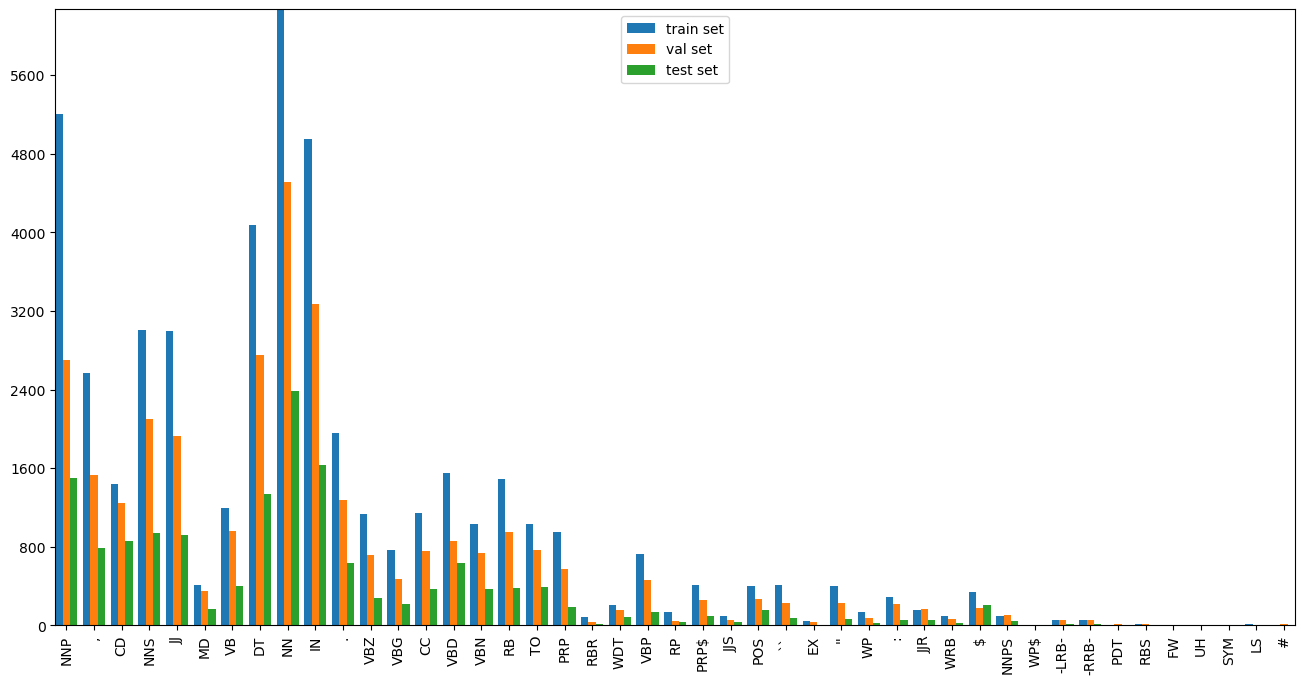

In [7]:
from utils.utils import *

#percentage_to_show = 0.005
percentage_to_show = 0.01

train_tags = np.array(' '.join((df.loc[df['split'] == "train"])['tag'].tolist()).split(" "))
validation_tags = np.array(' '.join((df.loc[df['split'] == "validation"])['tag'].tolist()).split(" "))
test_tags = np.array(' '.join((df.loc[df['split'] == "test"])['tag'].tolist()).split(" "))


hist_plot(train_tags, validation_tags, test_tags)   

Zooming in to better check the minority classes

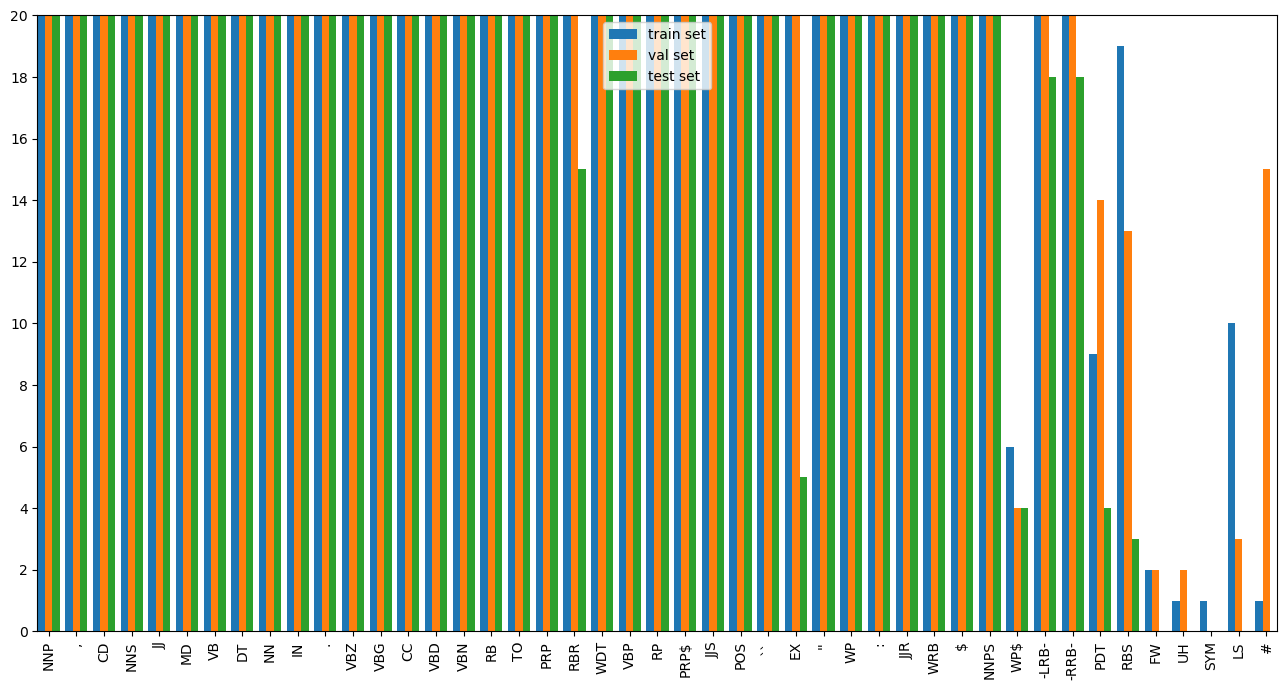

In [8]:
hist_plot(train_tags, validation_tags, test_tags, y_lim = 20)  

## Handling OOV Terms Utilities

In [9]:
def jaccard(set1, set2):
  n_intersection = len(set1.intersection(set2))
  n_union = len(set1) + len(set2) - n_intersection
  return n_intersection/n_union

def grams(word, n):
  return {''.join(gram) for gram in ngrams([c for c in word], n)}

class OOV_Terms_Embedder():
  def __init__(self, low=-0.05, high=0.05):
    self.low = low
    self.high = high
    self.embedding_model = None
    self.embedding_dimension = None

  def __call__(self, word:str, embedding_dimension:int, embedding_model: gensim.models.keyedvectors.KeyedVectors):
    return (np.random.uniform(low=self.low, high=self.high, size=embedding_dimension), 0)

class OOV_Terms_Embedder_Lower(OOV_Terms_Embedder):
  def __call__(self, word:str, embedding_dimension:int, embedding_model: gensim.models.keyedvectors.KeyedVectors):
    embedding_vocabulary = set(embedding_model.vocab.keys())
    lower_word = word.lower()
    if lower_word in embedding_vocabulary: # LOWER CASE WORD EMBEDDING FOUNDED IN embedding_model IS RETURNED
      return (embedding_model[lower_word], 1)
    else:
      return (np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension), 0)

class OOV_Terms_Embedder_Grams(OOV_Terms_Embedder_Lower):
  def __init__(self, n, treshold):
    self.n = n # NGRAMS CONSIDERED FOR WORDS SIMILARITY
    self.treshold = treshold # TRESHOLD CONSIDERED FOR WORD SIMILARITY WITH JACCARD

    self.embedding_model = None
    self.embedding_dimension = None
    self.embedding_vocabulary = None
    self.embedding_vocabulary_grams = dict()

  def __call__(self, word:str, embedding_dimension:int, embedding_model: gensim.models.keyedvectors.KeyedVectors):
    assert self.embedding_dimension == embedding_dimension if self.embedding_dimension != None else True
    assert self.embedding_model is embedding_model if self.embedding_model != None else True
    if self.embedding_dimension == None:
      self.embedding_dimension = embedding_dimension
      self.embedding_model = embedding_model
      self.embedding_vocabulary = embedding_model.vocab.keys()

    lower_word = word.lower()
    if lower_word in self.embedding_vocabulary: # LOWER CASE WORD EMBEDDING FOUNDED IN embedding_model IS RETURNED
      return (embedding_model[lower_word], 1)
    else:
      similar_words = []
      gram_word = grams(lower_word,self.n)
      for embedding_word in self.embedding_vocabulary:
        if embedding_word not in self.embedding_vocabulary_grams.keys():
          self.embedding_vocabulary_grams[embedding_word] = grams(embedding_word,self.n)
        if jaccard(gram_word, self.embedding_vocabulary_grams[embedding_word]) > self.treshold:
          similar_words.append(embedding_word)
      if len(similar_words) == 0: # NO SIMILAR WORDS FOUND IN embedding_model THEREFORE RANDOM VECTOR IS RETURNED
        return (np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension), 0)
      else: # MEAN OF SIMILAR WORDS FOUNDED IN embedding_model IS RETURNED
        word_embedding = np.zeros(embedding_dimension)
        for similar_word in similar_words:
          word_embedding += embedding_model[similar_word]
        return (word_embedding/len(similar_words), 2)

## Definition of Keras Tokenizer

In [10]:
import gensim.downloader as gloader
from typing import List, Callable, Dict
from tqdm import tqdm

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    print('Loading embedding model! It may take a while...')

    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

def build_embedding_matrix(choosed_embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str],
                           oov_terms_embedding:OOV_Terms_Embedder,
                           embedding_model: gensim.models.keyedvectors.KeyedVectors = None) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param choosed_embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)
    :param embedding_model: extended choosed_embedding_model with oov words embedding of previous steps (gensim wrapper)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    if embedding_model == None:
        embedding_model = choosed_embedding_model
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    counts = [0, 0, 0] # random_count, lower_count, grams_count
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError): # THE 'UNK' TOKEN IS HANDLED LIKE A COMMON WORLD (IF IT ISN'T IN THE GLOVE EMBEDDING ALREADY)
            embedding_vector, i = oov_terms_embedding(word, embedding_dimension, choosed_embedding_model)
            counts[i] += 1

        embedding_matrix[idx] = embedding_vector
    print()
    print('in_vocabulary_count: '+str(len(word_to_idx)-sum(counts)))
    print('oov_count: '+str(sum(counts)))
    print('oov_random_count: '+str(counts[0]))
    print('oov_lower_count: '+str(counts[1]))
    print('oov_grams_count: '+str(counts[2]))
    return embedding_matrix

In [11]:
import tensorflow as tf
import collections


class KerasTokenizer(object):
    """
    A simple high-level wrapper for the Keras tokenizer.
    """

    def __init__(self, tokenizer_args=None, tokenizer_name='Tokenizer', oov_terms_embedding = OOV_Terms_Embedder(),
                  build_embedding_matrix=False, embedding_dimension=None,
                  embedding_model_type=None, embedding_model=None, choosed_embedding_model=None):
        if build_embedding_matrix:
            assert embedding_model_type is not None
            assert embedding_dimension is not None and type(embedding_dimension) == int
        self.tokenizer_name = tokenizer_name
        self.build_embedding_matrix = build_embedding_matrix
        self.embedding_dimension = embedding_dimension
        self.embedding_model_type = embedding_model_type
        self.choosed_embedding_model = choosed_embedding_model
        if embedding_model == None:
            self.embedding_model = choosed_embedding_model
        else:
            self.embedding_model = embedding_model
        self.embedding_matrix = None
        self.vocab = None
        tokenizer_args = {} if tokenizer_args is None else tokenizer_args
        assert isinstance(tokenizer_args, dict) or isinstance(tokenizer_args, collections.OrderedDict)
        self.tokenizer_args = tokenizer_args
        self.oov_terms_embedding = oov_terms_embedding

    def build_vocab(self, data, **kwargs):
        print(f'Fitting {self.tokenizer_name}...')
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(**self.tokenizer_args)
        self.tokenizer.fit_on_texts(data)
        print('Fit completed!')
        self.vocab = self.tokenizer.word_index # HERE IS ADDED ALSO 'UNK' TO THE VOCABULARY
        if self.build_embedding_matrix:
            
            print('Checking OOV terms...')
            self.oov_terms = check_OOV_terms(embedding_model=self.embedding_model,
                                             word_listing=list(self.vocab.keys()))

            print('Building the embedding matrix...')
            self.embedding_matrix = build_embedding_matrix(embedding_model=self.embedding_model,
                                                           choosed_embedding_model=self.choosed_embedding_model,
                                                           word_to_idx=self.vocab,
                                                           vocab_size=len(self.vocab) + 1,          
                                                           embedding_dimension=self.embedding_dimension,
                                                           oov_terms=self.oov_terms,
                                                           oov_terms_embedding=self.oov_terms_embedding)
            print('Done!')


    def get_info(self):
        return {
            'build_embedding_matrix': self.build_embedding_matrix,
            'embedding_dimension': self.embedding_dimension,
            'embedding_model_type': self.embedding_model_type,
            'embedding_matrix': self.embedding_matrix.shape if self.embedding_matrix is not None else self.embedding_matrix,
            'embedding_model': self.embedding_model,
            'vocab_size': len(self.vocab) + 1,
        }

    def tokenize(self, text):
        return text

    def generate_embedding_model(self, array=None) -> gensim.models.keyedvectors.KeyedVectors:
      if array==None:
        array = self.embedding_matrix[1:,:] # IT WILL DROP THE EMBEDDING OF THE PADDING TOKEN (which is full of zeros)
      words = list(self.vocab.keys())
      model = self.embedding_model
      model.add(words,array, replace=True)
      return model

    def convert_tokens_to_ids(self, tokens):
        if type(tokens) == str:
            return self.tokenizer.texts_to_sequences([tokens])[0]
        else:
            return self.tokenizer.texts_to_sequences(tokens)

    def convert_ids_to_tokens(self, ids):
        return self.tokenizer.sequences_to_texts(ids)

## Building the Vocabulary and the Embedding Matrix

### Managing OOVs

The embedding of the words is obtained from GloVe. We use a technique that transforms OOVs (Out Of Vocabulary words) in their corresponding lowercase version to perform againa a search in GloVe - if this doesn't happen, a random embedding is generated. We've also tried to give an embedding based on trigrams - but this didn't give better results than random embeddings, probably because the embeddings in glove are semantic rather than syntactic.

### Vocabulary construction

The vocabulary used was built incrementally: starting from the set of embeddings of the words in the training set that were represented in GloVe (V1), the embeddings of the OOVs of the train set (OOV1) are generated and added to the orginal set (V2 = V1+OOV1). The words in the validation set that are not in the previously created set (OOV2) are generated and added to the previous set (V3 = V2 + OOV2). The final vocabulary is obtained agenerating the embeddings for the words in the test set which are not in the previously obtained set (OOV3) and adding them to the previous set (V4 = V3 + OOV3). 

Notice that using a vocabulary that is built using the whole dataset is not considered "cheating" on the scores, because the words in the validation and test set that are not present in the train set are seen by the model just during validation and test (and not during training).

### Embedding version and length choice

We've tried all the 4 kinds of GloVe embeddings (length 50, 100, 200, 300). The Glove 300 is the one that should be the more expressive one, but that dimension requires also to increase the expressiveness of the model (and therefore the number of parameters, layers and the overall complexity). We started from Glove 50 and we've later switched to Glove 100 because it gave us better results with marginal modifications to the model. The final models are trained/tested using Glove 100.

In [12]:
# SPLITTING DATA IN TRAIN,VALIDATION,TEST
train_data = df[df['split'] == 'train']
validation_data = df[df['split'] == 'validation']
test_data = df[df['split'] == 'test']

x_train = train_data['text'].values
x_val = validation_data['text'].values
x_test = test_data['text'].values

y_train = train_data['tag'].values
y_val = validation_data['tag'].values
y_test = test_data['tag'].values

# TWEAKABLE PARAMETERS

embedding_dimension = 100 # (50, 100, 200, 300) word2vec and fasttext works only with 300
embedding_model_type = "glove"
#embedding_model_type = "word2vec"
#embedding_model_type = "fasttext"

#oov_terms_embedding = OOV_Terms_Embedder()
oov_terms_embedding = OOV_Terms_Embedder_Lower()
#oov_terms_embedding = OOV_Terms_Embedder_Grams(n=3, treshold=0.6)

# TOKENIZER FOR THE TAGS

tokenizer_args = {
    'filters': '\t\n', # a string where each element is a character that will be filtered from the texts. The default is all punctuation, plus tabs and line breaks, minus the ' character.
    'lower': False
}

pos_tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args, tokenizer_name='pos_tokenizer')
pos_tokenizer.build_vocab(df['tag'].values) # BUILDING THE TAG TOKENIZER USING ALL THE DATASET (using train data not all the tags would've been considered)

# TOKENIZERS FOR THE WORDS OF THE SENTENCES(INCREMENTALLY BUILT AS DESCRIBED IN THE PROCEDURE)
tokenizer_args['oov_token'] = 'UNK'

choosed_embedding_model = load_embedding_model(model_type=embedding_model_type, embedding_dimension=embedding_dimension)

# V2 as V1 + OOV1
train_tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args,
                           tokenizer_name='train_tokenizer',
                           build_embedding_matrix=True,
                           embedding_dimension=embedding_dimension,
                           embedding_model_type=embedding_model_type,
                           choosed_embedding_model = choosed_embedding_model,
                           oov_terms_embedding=oov_terms_embedding)

train_tokenizer.build_vocab(df[df['split'] == 'train']['text'].values)
train_tokenizer_info = train_tokenizer.get_info()
print(f'train_tokenizer info: {train_tokenizer_info}')
print()

# V3 as V2 + OOV2
train_val_tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args,
                           tokenizer_name='train_val_tokenizer',
                           build_embedding_matrix=True,
                           embedding_dimension=embedding_dimension,
                           embedding_model_type=embedding_model_type,
                           choosed_embedding_model = choosed_embedding_model,
                           embedding_model = train_tokenizer.generate_embedding_model(),
                           oov_terms_embedding=oov_terms_embedding)

train_val_tokenizer.build_vocab(df[df['split'].isin(['train','validation'])]['text'].values)
train_val_tokenizer_info = train_val_tokenizer.get_info()
print(f'train_val_tokenizer info: {train_val_tokenizer_info}')
print()

# V4 as V3 + OOV3
tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args,
                           tokenizer_name='tokenizer',
                           build_embedding_matrix=True,
                           embedding_dimension=embedding_dimension,
                           embedding_model_type=embedding_model_type,
                           choosed_embedding_model = choosed_embedding_model,
                           embedding_model = train_val_tokenizer.generate_embedding_model(),
                           oov_terms_embedding=oov_terms_embedding)

tokenizer.build_vocab(df['text'].values)
tokenizer_info = tokenizer.get_info()
print(f'tokenizer info: {tokenizer_info}')
print()

Fitting pos_tokenizer...
Fit completed!
Loading embedding model! It may take a while...
Fitting train_tokenizer...
Fit completed!
Checking OOV terms...
Building the embedding matrix...


100%|██████████████████████████████████████████████████████████████████████████████| 8010/8010 [02:16<00:00, 58.64it/s]



in_vocabulary_count: 5663
oov_count: 2347
oov_random_count: 364
oov_lower_count: 1983
oov_grams_count: 0
Done!
train_tokenizer info: {'build_embedding_matrix': True, 'embedding_dimension': 100, 'embedding_model_type': 'glove', 'embedding_matrix': (8011, 100), 'embedding_model': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000002808C412B20>, 'vocab_size': 8011}

Fitting train_val_tokenizer...
Fit completed!
Checking OOV terms...
Building the embedding matrix...


100%|███████████████████████████████████████████████████████████████████████████| 10820/10820 [00:53<00:00, 200.67it/s]



in_vocabulary_count: 9876
oov_count: 944
oov_random_count: 190
oov_lower_count: 754
oov_grams_count: 0
Done!
train_val_tokenizer info: {'build_embedding_matrix': True, 'embedding_dimension': 100, 'embedding_model_type': 'glove', 'embedding_matrix': (10821, 100), 'embedding_model': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000002808C412B20>, 'vocab_size': 10821}

Fitting tokenizer...
Fit completed!
Checking OOV terms...
Building the embedding matrix...


100%|███████████████████████████████████████████████████████████████████████████| 11969/11969 [00:25<00:00, 474.71it/s]


in_vocabulary_count: 11514
oov_count: 455
oov_random_count: 129
oov_lower_count: 326
oov_grams_count: 0
Done!
tokenizer info: {'build_embedding_matrix': True, 'embedding_dimension': 100, 'embedding_model_type': 'glove', 'embedding_matrix': (11970, 100), 'embedding_model': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000002808C412B20>, 'vocab_size': 11970}



## Prepare data for NNs

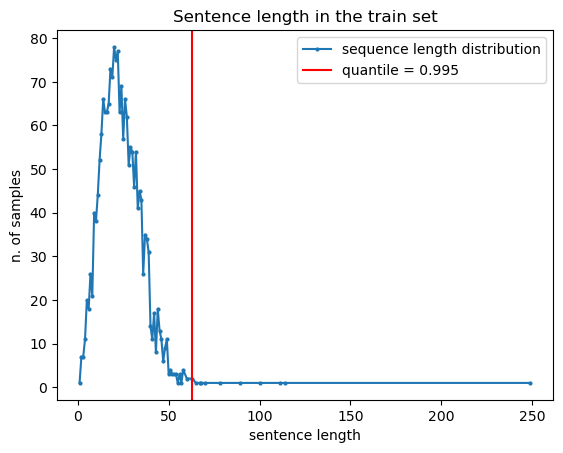

Max token sequence: 63
X train shape: (1963, 63)
Y train shape: (1963, 63, 46)
X val shape: (1299, 63)
Y val shape: (1299, 63, 46)
X test shape: (652, 63)
Y test shape: (652, 63, 46)


In [13]:
def convert_text(texts, tokenizer, quantile = None, is_training=False, max_seq_length=None):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :tokenizer: an instantiated tokenizer
    :quantile: (used during fitting) the quantile through which the fixed length of the sequences is chosen
    :is_training: whether input texts are from the training split or not
    :max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
        max_seq_length: the max token sequence previously computed with
        training texts.
    """
    text_ids = tokenizer.convert_tokens_to_ids(texts)

    # Padding
    if is_training:
        max_seq_length = int(np.quantile([len(seq) for seq in text_ids], quantile))
    else:
        assert max_seq_length is not None

    text_ids = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids]
    text_ids = np.array([seq[:max_seq_length] for seq in text_ids])

    if is_training:
        return text_ids, max_seq_length
    else:
        return text_ids

# ENCODING AND PADDING ARE HANDLED BY convert_text FUNCTION
# LABELS ARE EXTENDED TO REPRESENT A ONE-HOT-ENCODING OF THE TAG FOR EACH SAMPLE AND TOKEN

quantile = 0.995 # quantile chosen to cut sentence length, from 0 to 1, median is 0.5    
    
plot_sentence_length_dist(x_train, tokenizer, quantile, "train set")


# Train

x_train, max_seq_length = convert_text(texts=x_train, tokenizer=tokenizer, quantile = quantile, is_training=True)
y_train = convert_text(texts=y_train, tokenizer=pos_tokenizer, is_training=False, max_seq_length=max_seq_length)
y_train = tf.keras.utils.to_categorical(y_train,len(pos_tokenizer.vocab)+1)
print(f"Max token sequence: {max_seq_length}")
print(f'X train shape: {x_train.shape}')
print(f'Y train shape: {y_train.shape}')

# Val
x_val = convert_text(texts=x_val, tokenizer=tokenizer, is_training=False, max_seq_length=max_seq_length)
y_val = convert_text(texts=y_val, tokenizer=pos_tokenizer, is_training=False, max_seq_length=max_seq_length)
y_val = tf.keras.utils.to_categorical(y_val,len(pos_tokenizer.vocab)+1)
print(f'X val shape: {x_val.shape}')
print(f'Y val shape: {y_val.shape}')

# Test
x_test = convert_text(texts=x_test, tokenizer=tokenizer, is_training=False, max_seq_length=max_seq_length)
y_test = convert_text(texts=y_test, tokenizer=pos_tokenizer, is_training=False, max_seq_length=max_seq_length)
y_test = tf.keras.utils.to_categorical(y_test,len(pos_tokenizer.vocab)+1)
print(f'X test shape: {x_test.shape}')
print(f'Y test shape: {y_test.shape}')

The quantile used to cut the sentences was chosen after various trials: smaller quantiles give lower scores because we're cutting too much of the rest of the sentence while bigger quantiles give lower score because we're padding too much the shorter sequences. 

## Definition of the metrics

The $F_1$ score is a metric that is computed with the following formula (check [this link](https://it.wikipedia.org/wiki/F1_score) for more insights on the metric):

$$F_{\beta} = \frac{(1+\beta^2) \cdot TP}{(1+\beta^2)\cdot TP + \beta^2 \cdot FN + FP}$$

In the case of $\beta = 1$,

$$F_{1} = \frac{2 \cdot TP}{2\cdot TP + FN + FP}$$

And, if we consider the confusion matrix $C_{nxn}$, for each class $i \in \{1..n\}$ we have

$$F_{1,i} = \frac{2 \cdot {TP}_i}{2\cdot {TP}_i + {FN}_i + {FP}_i}$$



$${TP}_i = C(i,i) \qquad {FN}_i = \sum_{j \in 1..n}{C(i,j)} - {TP}_i \qquad FP_i = \sum_{j \in 1..n}{C(j,i)} - {TP}_i$$

Which are aggregated in the final metric, every class having the same weight:
$$Macro-F_{1} = \frac{\sum_{}{F_{1,i}}}{n}$$

To avoid considering punctuation,symbols and padding, we remove the corresponding columns and rows directly from the confusion matrix $C$ before computing this metric *as suggested by the tutors*.

In [14]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

class Metric():
  def __call__(self,y_true,y_pred):
    pass

  def reshape_inputs(self, y_pred, y_true):
    y_pred_shape = y_pred.shape
    n_samples = np.prod([size for size in y_pred_shape[:-1]])
    y_dim = y_pred_shape[-1]

    y_pred = np.reshape(y_pred,(n_samples, y_dim))
    y_true = np.reshape(y_true,(n_samples, y_dim))

    if self.categorical:
      y_pred = np.argmax(y_pred, axis=-1)
      y_true = np.argmax(y_true, axis=-1)
    
    return y_pred, y_true

class Cm_Metric(Metric):
  def __init__(self, categorical=False, remove_classes=[]):
    self.categorical = categorical
    self.remove_classes = remove_classes

  def build_confusion_matrix(self, y_pred, y_true):
    y_pred, y_true = self.reshape_inputs(y_pred, y_true)

    mask = np.ones(len(y_pred),dtype='bool')
    
    for i in range(len(y_pred)):
        for to_remove in self.remove_classes:
            if (y_pred[i] == to_remove or y_true[i] == to_remove):
                mask[i] = False
            
    cm = confusion_matrix(y_true[mask], y_pred[mask])
    self.cm = cm

    return self.cm

class Accuracy_Metric(Cm_Metric):
  def __init__(self, categorical=False, remove_classes=[]):
    super().__init__(categorical=categorical,remove_classes=remove_classes)

  def __call__(self, y_pred, y_true):
    self.build_confusion_matrix(y_pred,y_true)
    return np.sum([self.cm[i,i] for i in range(self.cm.shape[0])])/np.sum(self.cm)

class F1_Metric(Cm_Metric):
  def __init__(self, average=None, categorical=False, remove_classes=[]):
    super().__init__(categorical=categorical,remove_classes=remove_classes)
    self.average = average

  def __call__(self, y_pred, y_true):
    self.build_confusion_matrix(y_pred,y_true)

    true_positives = np.array([self.cm[i,i] for i in range(self.cm.shape[0])])
    false_negatives = np.sum(self.cm,axis=1)-true_positives
    false_positives = np.sum(self.cm,axis=0)-true_positives

    tmp = 2*true_positives+false_positives+false_negatives
    if (tmp==0).any():
      print('division by 0 in calculations of f1s')
      print('true_positives: ', true_positives[tmp==0])
      print('false_positives: ', false_positives[tmp==0])
      print('false_negatives: ', false_negatives[tmp==0])
      print('relative_indexes: ', [i for i,b in enumerate(tmp==0) if b])
      tmp[tmp==0]=1
    f1s = 2*true_positives/tmp
    if self.average == 'macro':
      return np.mean(f1s)
    if self.average == None:
      return f1s

class Sklearn_Metric(Metric):
  def __init__(self, categorical=False, sample_weights=None):
    self.categorical = categorical
    self.sample_weights = sample_weights

  def reshape_inputs(self,y_pred, y_true):
    y_pred, y_true = super().reshape_inputs(y_pred, y_true)
    
    sample_weights = self.sample_weights
    if sample_weights is not None:
      sample_weights = np.reshape(self.sample_weights,(y_pred.shape[0],))

    return y_pred, y_true, sample_weights

class Sklearn_Accuracy_Metric(Sklearn_Metric):
  def __init__(self, categorical=False, sample_weights=None):
    super().__init__(categorical=categorical,sample_weights=sample_weights)

  def __call__(self, y_pred, y_true):
    y_pred, y_true, sample_weights = self.reshape_inputs(y_pred, y_true)
    return accuracy_score(y_true,y_pred, sample_weight=sample_weights)

class Sklearn_F1_Metric(Sklearn_Metric):
  def __init__(self, average=None, categorical=False, sample_weights=None):
    super().__init__(categorical=categorical,sample_weights=sample_weights)
    self.average = average

  def __call__(self, y_pred, y_true):
    y_pred, y_true, sample_weights = self.reshape_inputs(y_pred, y_true)
    return f1_score(y_true,y_pred, average=self.average, sample_weight=sample_weights)


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

def plot_confusion(cm, plt_size=(16,10), labels=None):
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  ax = plt.gca()
  ax.grid(False)
  set_size(plt_size[0],plt_size[1],ax=ax)
  disp.plot(ax=ax)

## Import custom interface to build the NNs models

In [15]:
from utils.models_interface import *

# Global settings to run tests

In [16]:
# punctuations on the wikipedia page
# wiki_punctuations = {'.',',','"', "'",'-','?',':','!',';'}
# list used to remove punctuation tags found in the dataset
dataset_punctuations = {'``',':','.','$',"''",'#',',','-LRB-','-RRB-','LS'}
# tensorflow standard punctuation filter of the tokenizer
#tf_punctuation_filter = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' 

# Baseline Model
This model has just a bi-directional layer of LSTM cells, in addition to the dense input layer (followed by the fixed embedding layer) and the dense time-distributed output layer.

## Creation of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 63, 100)          1197000   
                                                                 
 bidirectional_LSTM (Bidirec  (None, 63, 128)          84480     
 tional)                                                         
                                                                 
 logits (TimeDistributed)    (None, 63, 46)            5934      
                                                                 
Total params: 1,287,414
Trainable params: 90,414
Non-trainable params: 1,197,000
_________________________________________________________________


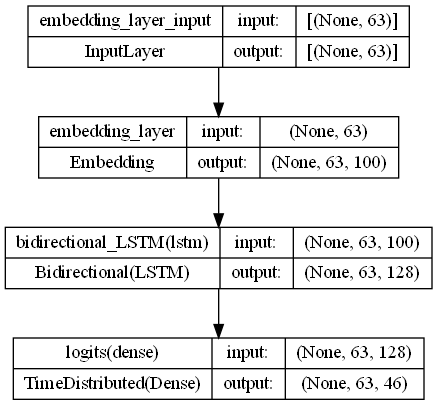

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

contextual_dimension = 64 # HYPER_PARAMETER(CONTEXTUAL WORD REPRESENTATION EMBEDDING DIMENSION)
learning_rate = 5e-3 # HYPER_PARAMETER

layers_info_bilstm = [
    {
        "layer_class": layers.Embedding,
        "output_dim": embedding_dimension,
        "input_dim": tokenizer_info['vocab_size'],
        "input_length": max_seq_length,
        "weights": tokenizer.embedding_matrix if tokenizer.embedding_matrix is None else [tokenizer.embedding_matrix],
        "mask_zero": True,
        "trainable": False,
        "name": "embedding_layer"
    },
    {
        "layer_class": layers.Bidirectional,
        "layer": layers.LSTM(contextual_dimension, return_sequences=True),
        "name": "bidirectional_LSTM"
    },
    {
        'layer_class': layers.TimeDistributed,
        'layer': layers.Dense(len(pos_tokenizer.vocab)+1, activation='softmax'),
        "name": "logits"
    }
]

compile_info_bilstm = {
    'optimizer': keras.optimizers.Adam(learning_rate=learning_rate),
    'loss': 'categorical_crossentropy',
    'metrics': [keras.metrics.CategoricalAccuracy()],
}

bilstm_model = create_model(layers_info_bilstm, compile_info_bilstm)
plot_model(bilstm_model, to_file="img/BiLSTM.png",show_shapes=True, show_layer_names=True)

## Training

Start training! 
Parameters: {'verbose': 1, 'epochs': 500, 'batch_size': 32, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000002808C4044F0>]}
Epoch 1/500
62/62 [==============================] - 20s 159ms/step - loss: 0.5898 - categorical_accuracy: 0.6109 - val_loss: 0.2660 - val_categorical_accuracy: 0.8191
Epoch 2/500
62/62 [==============================] - 7s 110ms/step - loss: 0.1931 - categorical_accuracy: 0.8631 - val_loss: 0.1717 - val_categorical_accuracy: 0.8745
Epoch 3/500
62/62 [==============================] - 7s 108ms/step - loss: 0.1359 - categorical_accuracy: 0.9015 - val_loss: 0.1402 - val_categorical_accuracy: 0.8952
Epoch 4/500
62/62 [==============================] - 7s 112ms/step - loss: 0.1091 - categorical_accuracy: 0.9196 - val_loss: 0.1259 - val_categorical_accuracy: 0.9032
Epoch 5/500
62/62 [==============================] - 7s 111ms/step - loss: 0.0904 - categorical_accuracy: 0.9333 - val_loss: 0.1170 - val_categorical_accuracy: 0.9103
Epoch 6/50

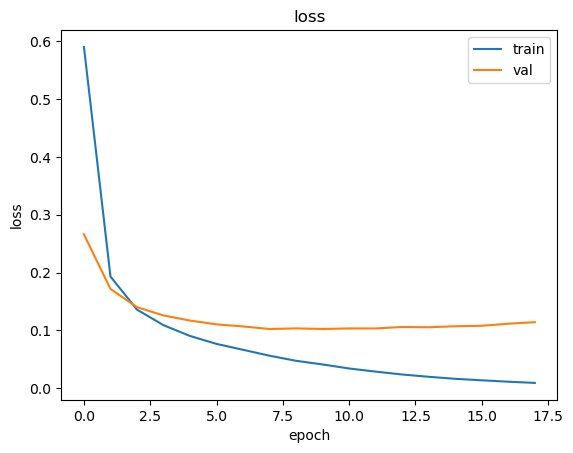

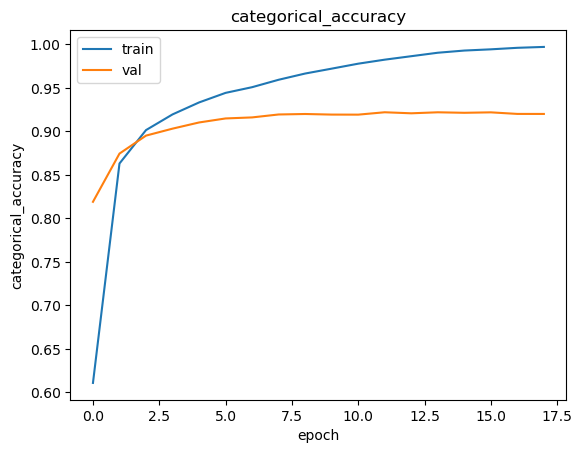

In [18]:
# Training
training_info_bilstm = {
    'verbose': 1,
    'epochs': 500,
    'batch_size': 32,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)]
}
bilstm_model = train_model(model=bilstm_model, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, training_info=training_info_bilstm)
#bilstm_model.save("models_weights/bilstm.h5")

## Prediction and Evaluation

In [19]:
from sklearn.preprocessing import normalize
from tensorflow.keras.models import load_model
from IPython.display import display, Markdown, Latex

#load saved weights
bilstm_model = load_model("models_weights/bilstm.h5")

# Inference
prediction_info_bilstm = {
    'batch_size': 64,
    'verbose': 1
}

# Validation Set Evaluation
display(Markdown('**Validation Set Prediction**'))
val_predictions_bilstm = predict_data(model=bilstm_model, x=x_val, prediction_info=prediction_info_bilstm)

remove_classes, pos_labels = obtain_remove_kept_tags(pos_tokenizer=pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = val_predictions_bilstm, gold_labels = y_val)

macro_f1 = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes)
accuracy = Accuracy_Metric(categorical=True,remove_classes=remove_classes)

val_metric_info = evaluate_predictions(predictions=val_predictions_bilstm,
                                   y= y_val,
                                   metrics=[macro_f1, accuracy],
                                   metric_names=["macro_f1", "accuracy"])
print()

# Test Set Evaluation
display(Markdown('**Test Set Prediction**'))
test_predictions_bilstm = predict_data(model=bilstm_model, x=x_test, 
                                  prediction_info=prediction_info_bilstm)

remove_classes, pos_labels = obtain_remove_kept_tags(pos_tokenizer=pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = test_predictions_bilstm, gold_labels = y_test)

macro_f1 = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes)
accuracy = Accuracy_Metric(categorical=True,remove_classes=remove_classes)

test_metric_info = evaluate_predictions(predictions=test_predictions_bilstm,
                                   y= y_test,
                                   metrics=[macro_f1, accuracy],
                                   metric_names=["macro_f1", "accuracy"])
print()

# print table with scores
display(Markdown(f'<table><tr><th>Baseline   </th><th>Validation</th><th>Test</th></tr><tr><th>macro-F1</th><td>{round(val_metric_info["macro_f1"],3)}</td><td>{round(test_metric_info["macro_f1"],3)}</td></tr><tr><th>Accuracy</th><td>{round(val_metric_info["accuracy"],3)}</td><td>{round(test_metric_info["accuracy"],3)}</td></tr></table>'))

**Validation Set Prediction**

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 1299 samples
21/21 [==============================] - 4s 30ms/step
Evaluating predictions! Total samples: 1299



**Test Set Prediction**

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 652 samples
11/11 [==============================] - 0s 29ms/step
Evaluating predictions! Total samples: 652



<table><tr><th>Baseline   </th><th>Validation</th><th>Test</th></tr><tr><th>macro-F1</th><td>0.799</td><td>0.85</td></tr><tr><th>Accuracy</th><td>0.912</td><td>0.917</td></tr></table>

# Double BiLSTM
Similar to the baseline, but with an additional bidirectional LSTM layer.

## Creation of the model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 63, 100)          1197000   
                                                                 
 bidirectional_LSTM_up (Bidi  (None, 63, 128)          84480     
 rectional)                                                      
                                                                 
 bidirectional_LSTM_down (Bi  (None, 63, 128)          98816     
 directional)                                                    
                                                                 
 logits (TimeDistributed)    (None, 63, 46)            5934      
                                                                 
Total params: 1,386,230
Trainable params: 189,230
Non-trainable params: 1,197,000
_________________________________________________________________


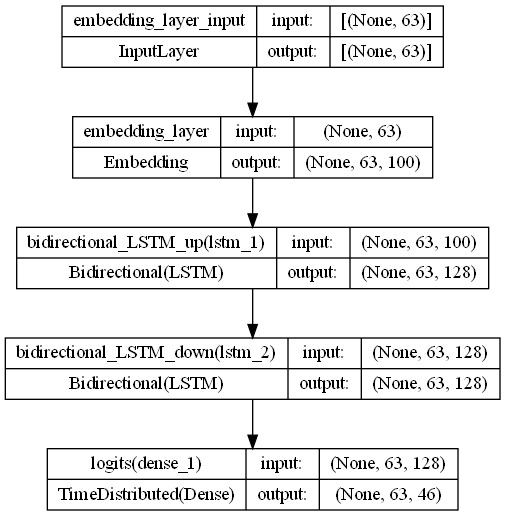

In [20]:
contextual_dimension = 64 # HYPER_PARAMETER(CONTEXTUAL WORD REPRESENTATION EMBEDDING DIMENSION)
learning_rate = 5e-3 # HYPER_PARAMETER

layers_info_double_bilstm = [
    {
        "layer_class": layers.Embedding,
        "output_dim": embedding_dimension,
        "input_dim": tokenizer_info['vocab_size'],
        "input_length": max_seq_length,
        "weights": tokenizer.embedding_matrix if tokenizer.embedding_matrix is None else [tokenizer.embedding_matrix],
        "mask_zero": True,
        "trainable": False,
        "name": "embedding_layer"
    },
    {
        "layer_class": layers.Bidirectional,
        "layer": layers.LSTM(contextual_dimension, return_sequences=True),
        "name": "bidirectional_LSTM_up"
    },
        {
        "layer_class": layers.Bidirectional,
        "layer": layers.LSTM(contextual_dimension, return_sequences=True),
        "name": "bidirectional_LSTM_down"
    },
    {
        'layer_class': layers.TimeDistributed,
        'layer': layers.Dense(len(pos_tokenizer.vocab)+1, activation='softmax'),
        "name": "logits"
    }
]

compile_info_double_bilstm = {
    'optimizer': keras.optimizers.Adam(learning_rate=learning_rate),
    'loss': 'categorical_crossentropy',
    'metrics': [keras.metrics.CategoricalAccuracy()],
}

double_bilstm_model = create_model(layers_info_double_bilstm, compile_info_double_bilstm)
plot_model(double_bilstm_model,to_file="img/double_bilstm.png", show_shapes=True, show_layer_names=True)

## Training

Start training! 
Parameters: {'verbose': 1, 'epochs': 500, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x00000280C6043D90>]}
Epoch 1/500
31/31 [==============================] - 33s 476ms/step - loss: 0.9491 - categorical_accuracy: 0.3374 - val_loss: 0.5685 - val_categorical_accuracy: 0.6035
Epoch 2/500
31/31 [==============================] - 8s 257ms/step - loss: 0.3792 - categorical_accuracy: 0.7317 - val_loss: 0.2771 - val_categorical_accuracy: 0.8070
Epoch 3/500
31/31 [==============================] - 8s 248ms/step - loss: 0.2117 - categorical_accuracy: 0.8519 - val_loss: 0.1908 - val_categorical_accuracy: 0.8662
Epoch 4/500
31/31 [==============================] - 8s 251ms/step - loss: 0.1519 - categorical_accuracy: 0.8926 - val_loss: 0.1547 - val_categorical_accuracy: 0.8864
Epoch 5/500
31/31 [==============================] - 7s 242ms/step - loss: 0.1207 - categorical_accuracy: 0.9126 - val_loss: 0.1381 - val_categorical_accuracy: 0.8980
Epoch 6/50

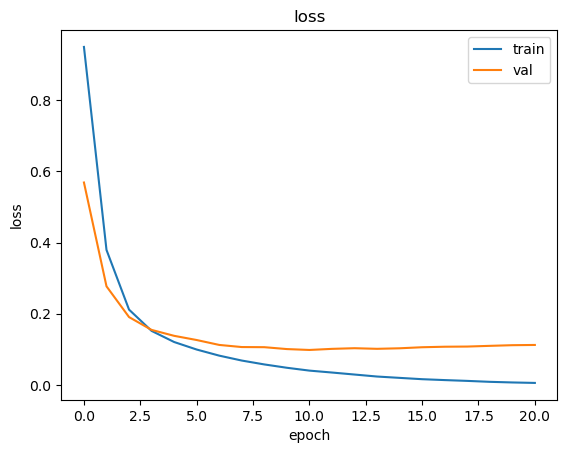

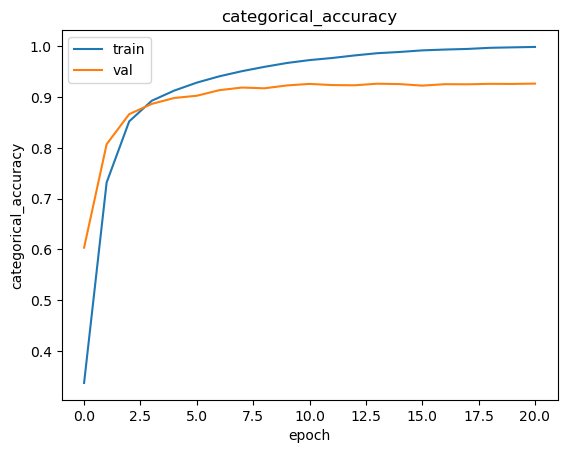

In [21]:
training_info_double_bilstm = {
    'verbose': 1,
    'epochs': 500,
    'batch_size': 64,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)]
}
double_bilstm_model = train_model(model=double_bilstm_model, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, training_info=training_info_double_bilstm)
#double_bilstm_model.save("models_weights/double_bilstm.h5")

## Prediction and Evaluation

In [22]:
from sklearn.preprocessing import normalize
from utils.utils import *
from tensorflow.keras.models import load_model
from IPython.display import display, Markdown, Latex

#load saved weights
double_bilstm_model = load_model("models_weights/double_bilstm.h5")

# Inference
prediction_info_double_bilstm = {
    'batch_size': 512,
    'verbose': 1
}


# Validation Set Evaluation
display(Markdown('**Validation Set Prediction**'))
val_predictions_double_bilstm = predict_data(model=double_bilstm_model, x=x_val, 
                                	 prediction_info=prediction_info_double_bilstm)

remove_classes, pos_labels = obtain_remove_kept_tags(pos_tokenizer=pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = val_predictions_double_bilstm, gold_labels = y_val)

macro_f1 = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes)
accuracy = Accuracy_Metric(categorical=True,remove_classes=remove_classes)

val_metric_info = evaluate_predictions(predictions=val_predictions_double_bilstm,
                                   y= y_val,
                                   metrics=[macro_f1, accuracy],
                                   metric_names=["macro_f1", "accuracy"])
print()

# Test Set Evaluation
display(Markdown('**Test Set Prediction**'))
test_predictions_double_bilstm = predict_data(model=double_bilstm_model, x=x_test, 
                                   prediction_info=prediction_info_double_bilstm)

remove_classes, pos_labels = obtain_remove_kept_tags(pos_tokenizer=pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = test_predictions_double_bilstm, gold_labels = y_test)

macro_f1 = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes)
accuracy = Accuracy_Metric(categorical=True,remove_classes=remove_classes)

test_metric_info = evaluate_predictions(predictions=test_predictions_double_bilstm,
                                   y= y_test,
                                   metrics=[macro_f1, accuracy],
                                   metric_names=["macro_f1", "accuracy"])
print()

# print table with scores
display(Markdown(f'<table><tr><th>Double BiLSTM</th><th>Validation</th><th>Test</th></tr><tr><th>macro-F1</th><td>{round(val_metric_info["macro_f1"],3)}</td><td>{round(test_metric_info["macro_f1"],3)}</td></tr><tr><th>Accuracy</th><td>{round(val_metric_info["accuracy"],3)}</td><td>{round(test_metric_info["accuracy"],3)}</td></tr></table>'))

**Validation Set Prediction**

Starting prediction: 
{'batch_size': 512, 'verbose': 1}
Predicting on 1299 samples
3/3 [==============================] - 8s 240ms/step
Evaluating predictions! Total samples: 1299



**Test Set Prediction**

Starting prediction: 
{'batch_size': 512, 'verbose': 1}
Predicting on 652 samples
2/2 [==============================] - 0s 103ms/step
Evaluating predictions! Total samples: 652



<table><tr><th>Double BiLSTM</th><th>Validation</th><th>Test</th></tr><tr><th>macro-F1</th><td>0.801</td><td>0.856</td></tr><tr><th>Accuracy</th><td>0.917</td><td>0.923</td></tr></table>

# Single BiLSTM + Dense

Similar to the baseline, but with an additional Dense distributed layer before the output layer.

## Creation of the model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 63, 100)          1197000   
                                                                 
 bidirectional_LSTM (Bidirec  (None, 63, 128)          84480     
 tional)                                                         
                                                                 
 dense (TimeDistributed)     (None, 63, 128)           16512     
                                                                 
 logits (TimeDistributed)    (None, 63, 46)            5934      
                                                                 
Total params: 1,303,926
Trainable params: 106,926
Non-trainable params: 1,197,000
_________________________________________________________________


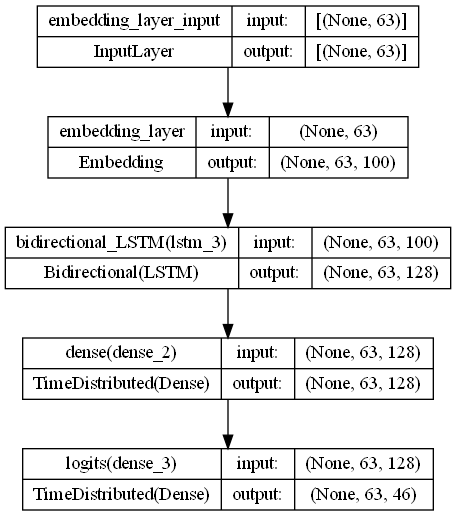

In [23]:
contextual_dimension = 64 # HYPER_PARAMETER(CONTEXTUAL WORD REPRESENTATION EMBEDDING DIMENSION)
compression_dimension = 128 # HYPER_PARAMETER(COMPRESSED CONTEXTUAL WORD REPRESENTATION EMBEDDING DIMENSION)
learning_rate = 1e-2 # HYPER_PARAMETER

layers_info_bilstm_dense = [
    {
        "layer_class": layers.Embedding,
        "output_dim": embedding_dimension,
        "input_dim": tokenizer_info['vocab_size'],
        "input_length": max_seq_length,
        "weights": tokenizer.embedding_matrix if tokenizer.embedding_matrix is None else [tokenizer.embedding_matrix],
        "mask_zero": True,
        "trainable": False,
        "name": "embedding_layer"
    },
    {
        "layer_class": layers.Bidirectional,
        "layer": layers.LSTM(contextual_dimension, return_sequences=True),
        "name": "bidirectional_LSTM"
    },
    {
        'layer_class': layers.TimeDistributed,
        'layer': layers.Dense(compression_dimension),
        "name": "dense"
    },
    {
        'layer_class': layers.TimeDistributed,
        'layer': layers.Dense(len(pos_tokenizer.vocab)+1, activation='softmax'),
        "name": "logits"
    }
]

compile_info_bilstm_dense = {
    'optimizer': keras.optimizers.Adam(learning_rate=learning_rate),
    'loss': 'categorical_crossentropy',
    'metrics': [keras.metrics.CategoricalAccuracy()],
}

bilstm_dense_model = create_model(layers_info_bilstm_dense, compile_info_bilstm_dense)
plot_model(bilstm_dense_model, to_file="img/BiLSTM_dense.png",show_shapes=True, show_layer_names=True)

## Training

Start training! 
Parameters: {'verbose': 1, 'epochs': 500, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x00000280E3EB7760>]}
Epoch 1/500
31/31 [==============================] - 18s 245ms/step - loss: 0.5768 - categorical_accuracy: 0.5871 - val_loss: 0.2259 - val_categorical_accuracy: 0.8350
Epoch 2/500
31/31 [==============================] - 5s 147ms/step - loss: 0.1643 - categorical_accuracy: 0.8759 - val_loss: 0.1462 - val_categorical_accuracy: 0.8846
Epoch 3/500
31/31 [==============================] - 4s 138ms/step - loss: 0.1059 - categorical_accuracy: 0.9177 - val_loss: 0.1172 - val_categorical_accuracy: 0.9098
Epoch 4/500
31/31 [==============================] - 4s 137ms/step - loss: 0.0771 - categorical_accuracy: 0.9399 - val_loss: 0.1106 - val_categorical_accuracy: 0.9131
Epoch 5/500
31/31 [==============================] - 4s 137ms/step - loss: 0.0575 - categorical_accuracy: 0.9548 - val_loss: 0.1063 - val_categorical_accuracy: 0.9202
Epoch 6/50

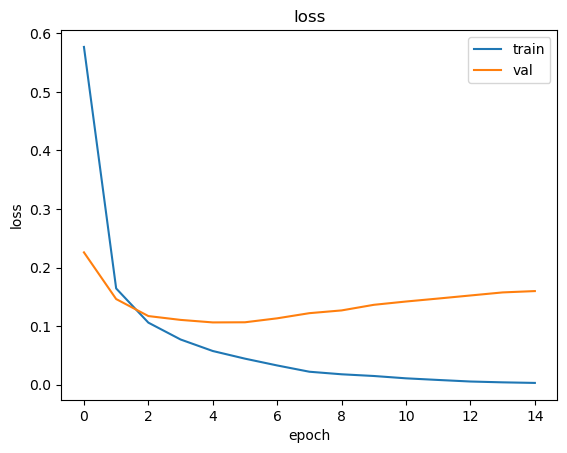

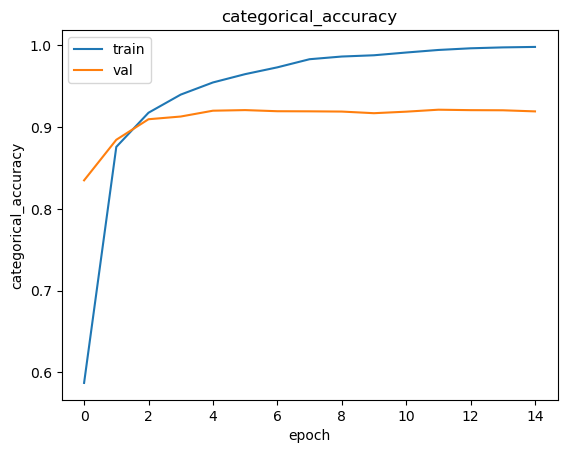

In [24]:
training_info_bilstm_dense = {
    'verbose': 1,
    'epochs': 500,
    'batch_size': 64,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)]
}
bilstm_dense_model = train_model(model=bilstm_dense_model, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, training_info=training_info_bilstm_dense)
#bilstm_dense_model.save("models_weights/bilstm_dense.h5")

## Prediction and Evaluation

In [25]:
from sklearn.preprocessing import normalize
from utils.utils import *
from tensorflow.keras.models import load_model
from IPython.display import display, Markdown, Latex

#load saved weights
bilstm_dense_model = load_model("models_weights/bilstm_dense.h5")

# Inference
prediction_info_bilstm_dense = {
    'batch_size': 512,
    'verbose': 1
}


# Validation Set Evaluation
display(Markdown('**Validation Set Prediction**'))
val_predictions_bilstm_dense = predict_data(model=bilstm_dense_model, x=x_val, 
                                   prediction_info=prediction_info_bilstm_dense)

remove_classes, pos_labels = obtain_remove_kept_tags(pos_tokenizer=pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = val_predictions_bilstm_dense, gold_labels = y_val)

macro_f1 = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes)
accuracy = Accuracy_Metric(categorical=True,remove_classes=remove_classes)

val_metric_info = evaluate_predictions(predictions=val_predictions_bilstm_dense,
                                   y= y_val,
                                   metrics=[macro_f1, accuracy],
                                   metric_names=["macro_f1", "accuracy"])
print()

# Test Set Evaluation
display(Markdown('**Test Set Prediction**'))
test_predictions_bilstm_dense = predict_data(model=bilstm_dense_model, x=x_test, prediction_info=prediction_info_bilstm_dense)

remove_classes, pos_labels = obtain_remove_kept_tags(pos_tokenizer=pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = test_predictions_bilstm_dense, gold_labels = y_test)

macro_f1 = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes)
accuracy = Accuracy_Metric(categorical=True,remove_classes=remove_classes)

test_metric_info = evaluate_predictions(predictions=test_predictions_bilstm_dense,
                                   y= y_test,
                                   metrics=[macro_f1, accuracy],
                                   metric_names=["macro_f1", "accuracy"])
print()

# print table with scores
display(Markdown(f'<table><tr><th>BiLSTM+Dense   </th><th>Validation</th><th>Test</th></tr><tr><th>macro-F1</th><td>{round(val_metric_info["macro_f1"],3)}</td><td>{round(test_metric_info["macro_f1"],3)}</td></tr><tr><th>Accuracy</th><td>{round(val_metric_info["accuracy"],3)}</td><td>{round(test_metric_info["accuracy"],3)}</td></tr></table>'))

**Validation Set Prediction**

Starting prediction: 
{'batch_size': 512, 'verbose': 1}
Predicting on 1299 samples
3/3 [==============================] - 4s 150ms/step
Evaluating predictions! Total samples: 1299



**Test Set Prediction**

Starting prediction: 
{'batch_size': 512, 'verbose': 1}
Predicting on 652 samples
2/2 [==============================] - 0s 71ms/step
Evaluating predictions! Total samples: 652



<table><tr><th>BiLSTM+Dense   </th><th>Validation</th><th>Test</th></tr><tr><th>macro-F1</th><td>0.763</td><td>0.85</td></tr><tr><th>Accuracy</th><td>0.913</td><td>0.922</td></tr></table>

# BiGRU
Similar to the baseline, but with a bi-directional GRU layer instead of a bi-directional LSTM layer.

## Creation of the model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 63, 100)          1197000   
                                                                 
 bidirectional_GRU_up (Bidir  (None, 63, 128)          63744     
 ectional)                                                       
                                                                 
 logits (TimeDistributed)    (None, 63, 46)            5934      
                                                                 
Total params: 1,266,678
Trainable params: 69,678
Non-trainable params: 1,197,000
_________________________________________________________________


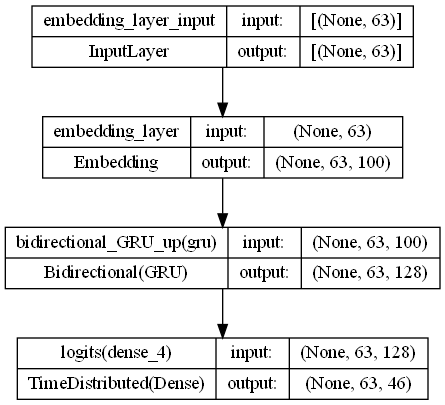

In [26]:
contextual_dimension = 64 # HYPER_PARAMETER(CONTEXTUAL WORD REPRESENTATION EMBEDDING DIMENSION)
learning_rate = 5e-3 # HYPER_PARAMETER

layers_info_bigru = [
    {
        "layer_class": layers.Embedding,
        "output_dim": embedding_dimension,
        "input_dim": tokenizer_info['vocab_size'],
        "input_length": max_seq_length,
        "weights": tokenizer.embedding_matrix if tokenizer.embedding_matrix is None else [tokenizer.embedding_matrix],
        "mask_zero": True,
        "trainable": False,
        "name": "embedding_layer"
    },
    {
        "layer_class": layers.Bidirectional,
        "layer": layers.GRU(contextual_dimension, return_sequences=True),
        "name": "bidirectional_GRU_up"
    },
    {
        'layer_class': layers.TimeDistributed,
        'layer': layers.Dense(len(pos_tokenizer.vocab)+1, activation='softmax'),
        "name": "logits"
    }
]

compile_info_bigru = {
    'optimizer': keras.optimizers.Adam(learning_rate=learning_rate),
    'loss': 'categorical_crossentropy',
    'metrics': [keras.metrics.CategoricalAccuracy()],
}


bigru_model = create_model(layers_info_bigru, compile_info_bigru)
plot_model(bigru_model , to_file="img/BiGRU.png",show_shapes=True, show_layer_names=True)

## Training

Start training! 
Parameters: {'verbose': 1, 'epochs': 500, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x00000281054779A0>]}
Epoch 1/500
31/31 [==============================] - 17s 242ms/step - loss: 0.6986 - categorical_accuracy: 0.5367 - val_loss: 0.3343 - val_categorical_accuracy: 0.7596
Epoch 2/500
31/31 [==============================] - 4s 130ms/step - loss: 0.2366 - categorical_accuracy: 0.8315 - val_loss: 0.1982 - val_categorical_accuracy: 0.8558
Epoch 3/500
31/31 [==============================] - 4s 129ms/step - loss: 0.1582 - categorical_accuracy: 0.8857 - val_loss: 0.1561 - val_categorical_accuracy: 0.8838
Epoch 4/500
31/31 [==============================] - 5s 147ms/step - loss: 0.1259 - categorical_accuracy: 0.9081 - val_loss: 0.1358 - val_categorical_accuracy: 0.8995
Epoch 5/500
31/31 [==============================] - 4s 132ms/step - loss: 0.1052 - categorical_accuracy: 0.9232 - val_loss: 0.1234 - val_categorical_accuracy: 0.9060
Epoch 6/50

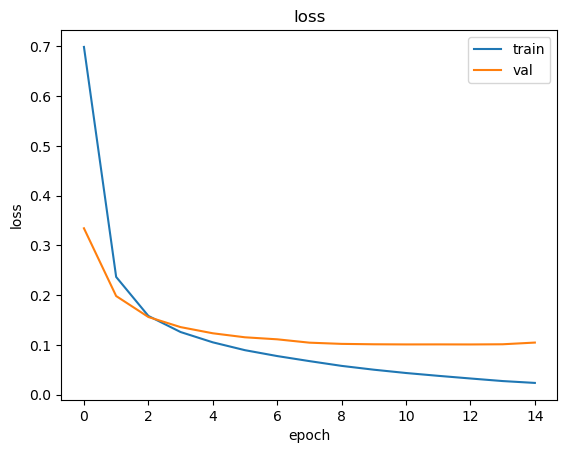

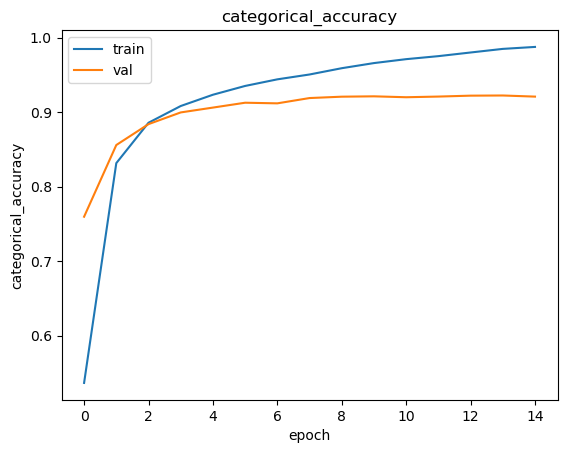

In [27]:
training_info_bigru = {
    'verbose': 1,
    'epochs': 500,
    'batch_size': 64,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)]
}
gru_model = train_model(model=bigru_model, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, training_info=training_info_bigru)
#gru_model.save("models_weights/gru.h5")

## Prediction and Evaluation

In [28]:
from sklearn.preprocessing import normalize
from utils.utils import *
from tensorflow.keras.models import load_model
from IPython.display import display, Markdown, Latex

#load saved weights
gru_model = load_model("models_weights/gru.h5")

# Inference
prediction_info_bigru = {
    'batch_size': 512,
    'verbose': 1
}

# Validation Set Evaluation
display(Markdown('**Validation Set Prediction**'))
val_predictions_bigru = predict_data(model=gru_model, x=x_val, prediction_info=prediction_info_bigru)

remove_classes, pos_labels = obtain_remove_kept_tags(pos_tokenizer=pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = val_predictions_bigru, gold_labels = y_val)

macro_f1 = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes)
accuracy = Accuracy_Metric(categorical=True,remove_classes=remove_classes)

val_metric_info = evaluate_predictions(predictions=val_predictions_bigru,
                                   y= y_val,
                                   metrics=[macro_f1, accuracy],
                                   metric_names=["macro_f1", "accuracy"])
print()

# Test Set Evaluation
display(Markdown('**Test Set Prediction**'))
test_predictions_bigru = predict_data(model=gru_model, x=x_test, prediction_info=prediction_info_bigru)

remove_classes, pos_labels = obtain_remove_kept_tags(pos_tokenizer=pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = test_predictions_bigru, gold_labels = y_test)

macro_f1 = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes)
accuracy = Accuracy_Metric(categorical=True,remove_classes=remove_classes)

test_metric_info = evaluate_predictions(predictions=test_predictions_bigru,
                                   y= y_test,
                                   metrics=[macro_f1, accuracy],
                                   metric_names=["macro_f1", "accuracy"])
print()


# print table with scores
display(Markdown(f'<table><tr><th>GRU   </th><th>Validation</th><th>Test</th></tr><tr><th>macro-F1</th><td>{round(val_metric_info["macro_f1"],3)}</td><td>{round(test_metric_info["macro_f1"],3)}</td></tr><tr><th>Accuracy</th><td>{round(val_metric_info["accuracy"],3)}</td><td>{round(test_metric_info["accuracy"],3)}</td></tr></table>'))

**Validation Set Prediction**

Starting prediction: 
{'batch_size': 512, 'verbose': 1}
Predicting on 1299 samples
3/3 [==============================] - 3s 112ms/step
Evaluating predictions! Total samples: 1299



**Test Set Prediction**

Starting prediction: 
{'batch_size': 512, 'verbose': 1}
Predicting on 652 samples
2/2 [==============================] - 0s 57ms/step
Evaluating predictions! Total samples: 652



<table><tr><th>GRU   </th><th>Validation</th><th>Test</th></tr><tr><th>macro-F1</th><td>0.798</td><td>0.864</td></tr><tr><th>Accuracy</th><td>0.914</td><td>0.921</td></tr></table>

# Error analysis

The two best models found are the Bi-LSTM (the baseline model) and the Bi-GRU: the macro-F1 scores of all the 4 models are very similar, but those two models are the ones having less parameters (90k, 70k). The GRU model has about 20k parameters and performs slightly better than the baseline, making it the best model found.
We'll proceed with the error analysis just on these 2 selected models.

The list of the used tags is linked [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

## POS tags distribution in the train set (punctuation, symbols and padding excluded)

First of all, we can proceed to analyze the distribution of the POS tags in the train set:

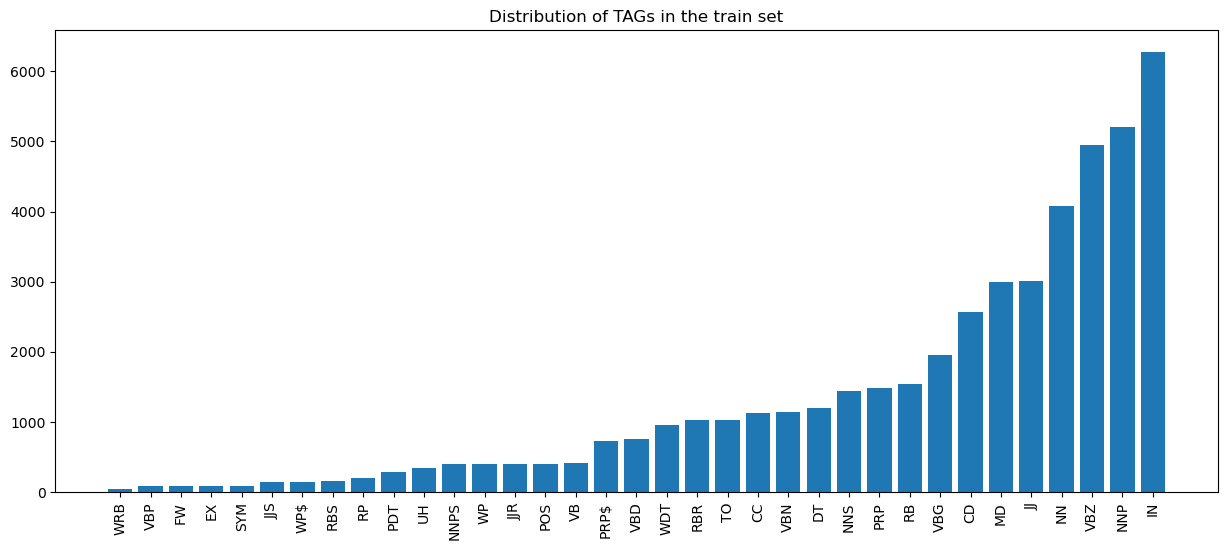

In [29]:
from collections import Counter


tags = Counter(train_tags).keys()
tags = [x for x in tags if x not in dataset_punctuations]
counts = Counter(train_tags).values()

counts, tags = zip(*sorted(zip(counts, tags)))


fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xticks(list(range(len(tags))), tags, rotation='vertical')
plt.title("Distribution of TAGs in the train set")
plt.bar(tags,counts)
plt.show()

## BiLSTM Error Analysis

### Metrics analysis and confusion matrixes

In [30]:
import seaborn as sns
from utils.error_analysis import *
from utils.utils import *


# Val data
remove_classes_val, pos_labels_val = obtain_remove_kept_tags(pos_tokenizer = pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = val_predictions_bilstm, gold_labels=y_val)

f1_val = F1_Metric(average=None,categorical=True,remove_classes=remove_classes_val)
f1_macro_val = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes_val)
accuracy_val = Accuracy_Metric(categorical=True,remove_classes=remove_classes_val)


val_metric_info = evaluate_predictions(predictions=val_predictions_bilstm,
                                   y= y_val,
                                   metrics=[f1_val, f1_macro_val],
                                   metric_names=["f1", "f1_macro"])



# Test data
remove_classes_test, pos_labels_test = obtain_remove_kept_tags(pos_tokenizer = pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = test_predictions_bilstm, gold_labels=y_test)

f1_test = F1_Metric(average=None,categorical=True,remove_classes=remove_classes_test)
f1_macro_test = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes_test)
accuracy_test = Accuracy_Metric(categorical=True,remove_classes=remove_classes_test)


test_metric_info = evaluate_predictions(predictions=test_predictions_bilstm,
                                   y= y_test,
                                   metrics=[f1_test, f1_macro_test],
                                   metric_names=["f1", "f1_macro"])


Evaluating predictions! Total samples: 1299
Evaluating predictions! Total samples: 652


detect the POS tags having the lowest $F_1$ score:

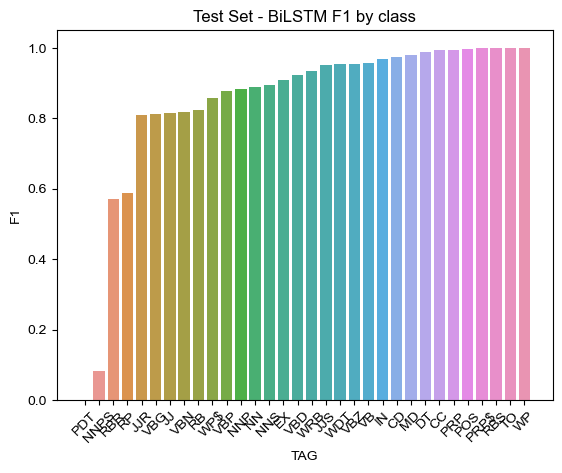

In [31]:
get_worst_errors(test_metric_info, pos_labels_test, plt_size=(10,6), title="Test Set - BiLSTM F1 by class");
plt.show()

We normalize by **rows** to study the recall of the POS tag classes

**Test set - confusion matrix normalized by rows**

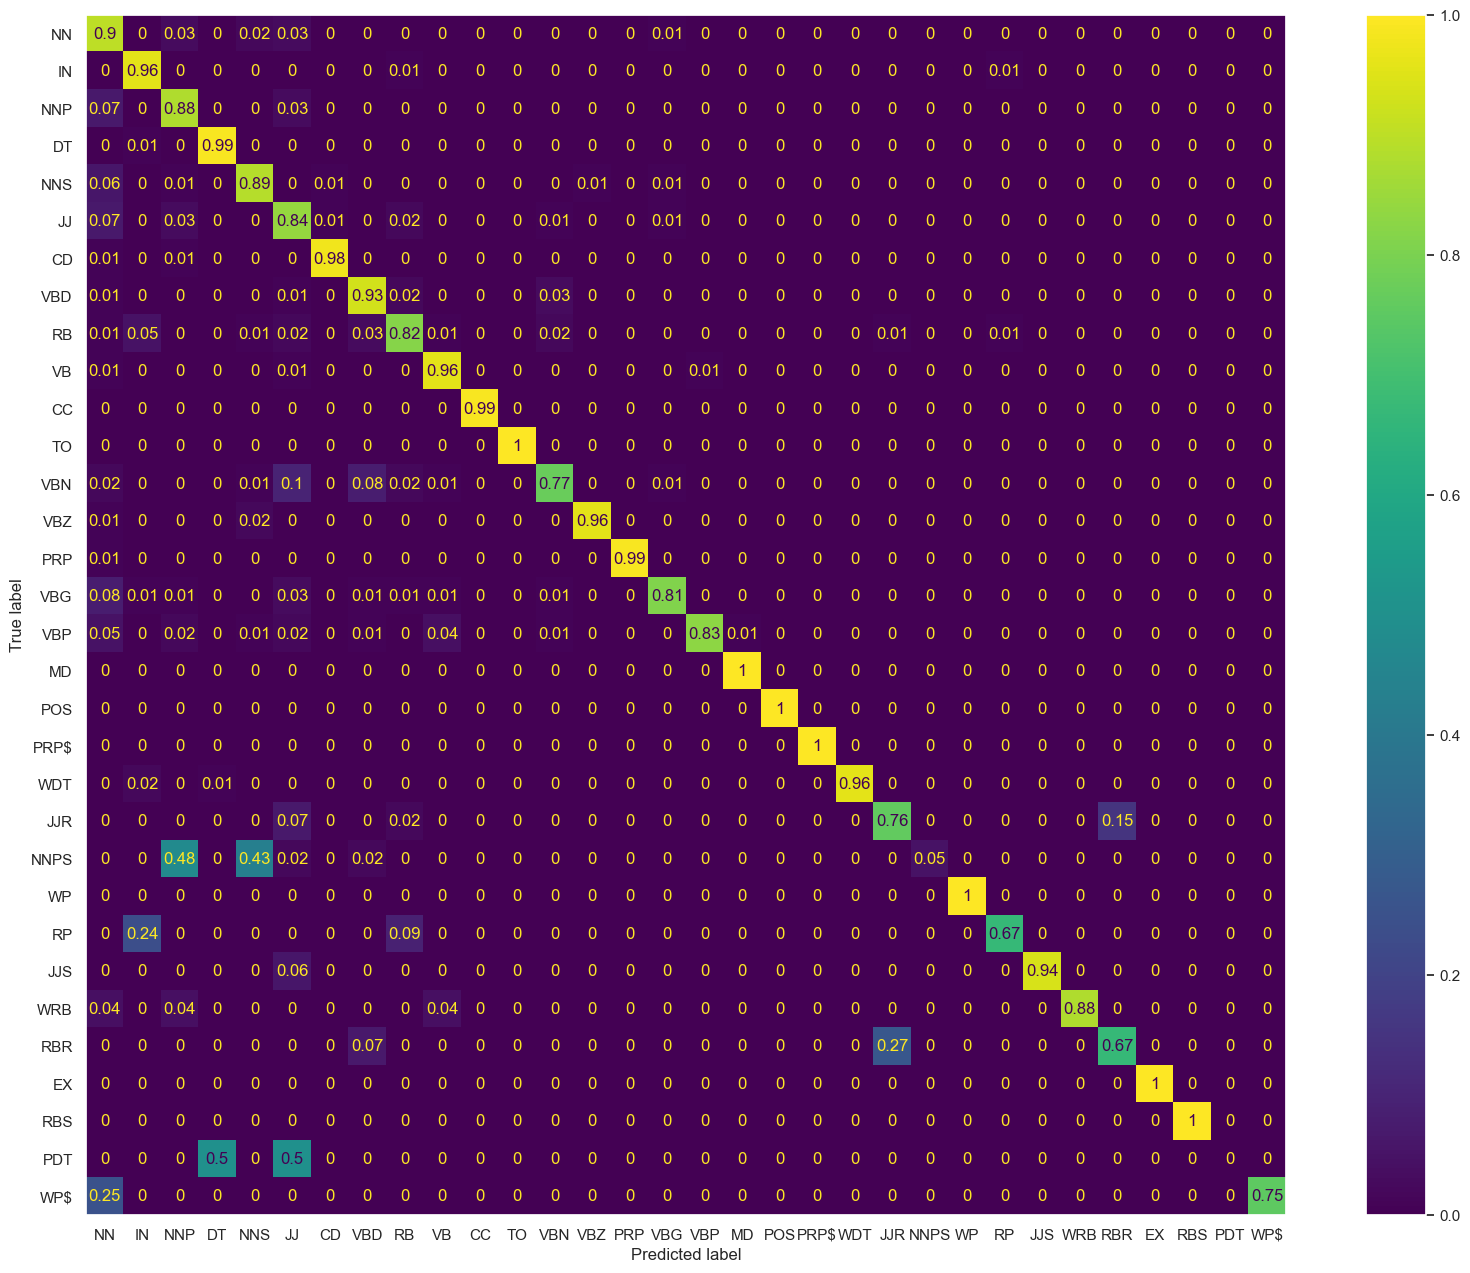

In [32]:
display(Markdown('**Test set - confusion matrix normalized by rows**'))
normalized_cm = np.around(normalize(f1_macro_test.cm, axis=1, norm='l1'), decimals = 2)
plot_confusion(normalized_cm, plt_size=(16,12),labels=pos_labels_test)

We take into account the classes having an $F_1$ score under 0.6, because they're the ones that mostly decrease the macro-F1 score (remembering that using macro, the most populated classes are weighted the same as the one that are the least populated, the same holds for the ones in the middle). 

- *PDT (Predeterminer)* is never guessed well, instead it is predicted as DT or JJ: this is because its numerosity in the train set (namely, its *support*) is under 10, as we can see from the paragraph *Overall dataset distribution*. Similar cases are the one of *RP (Particle)*.  there are some problematic cases - Some examples:
    - *all* is usually as DT (Determiner) or as PDT (Predeterminer), but it can also be RB (adverb). *all* is usually a DT (determiner) or a  PDT (predeterminer), but it can also be an RB (adverb).
    - *half* can be JJ (adjective), NN (noun) or a PDT (predeterminer). It is a JJ (adjective) if it immediately precedes a noun, a PDT (predeterminer) if it immediately precedes an article or a possessive pronoun, and a NN (noun) otherwise.
    - *many* is a PDT (predeterminer) when it immediately precedes an article. In general, however, it is an adjective (JJ), since it can be preceded by an article or a personal pronoun. 
    - *such* : Since any noun phrase can contain only one determiner, the fact that it can occur together with a determiner (as in t he only such case) means that it should generally be tagged as JJ (adjective). However, when it precedes a determiner, it should be tagged as PDT (predeterminer).

- *NNPS (Proper noun, plural)* are rarely predicted well: they're frequently mismatched with *NNS (Noun, plural)* and *NNP (Proper noun, singular)* which is expectable, because they're similar category tags. Notice also (from the train set distribution plotted in the above section) that while NNPS is a minority tag, *NNS* has about the double of its samples and *NNP* is a majority class. 
- *RBR (Adverb, comparative)* is sometimes wrongly predicted as *JJR (Adjective, comparative)*, this is because apart from being placed in similar places inside a sentence, there are some problematic cases reported - An example:
    - *more* should be tagged as a comparative adjective (JJR) when it is used without a head noun and it corresponds to the object of a verb or preposition. It should be tagged as a comparative adverb (RBR) when its use is parallel to other adverbs.

- *RP (Particle)* is sometimes predicted as *IN (Preposition or subordinating conjunction)*: Both prepositions and particles occur in collocation with verbs and are often difficult to distinguish from one another. Both prepositions and particles occur in collocation with verbs and are often difficult to distinguish from one another. Some conventions were taken by the annotators, which seem not directly learnt by the model.



Some of these investigations are obtained from [the official guide to this dataset](https://www.cis.upenn.edu/~bies/manuals/tagguide.pdf). To better investigate these errors, a good level of English is required. 

We normalize by **columns** to study the precision of the POS tag classes

**Test set - confusion matrix normalized by columns**

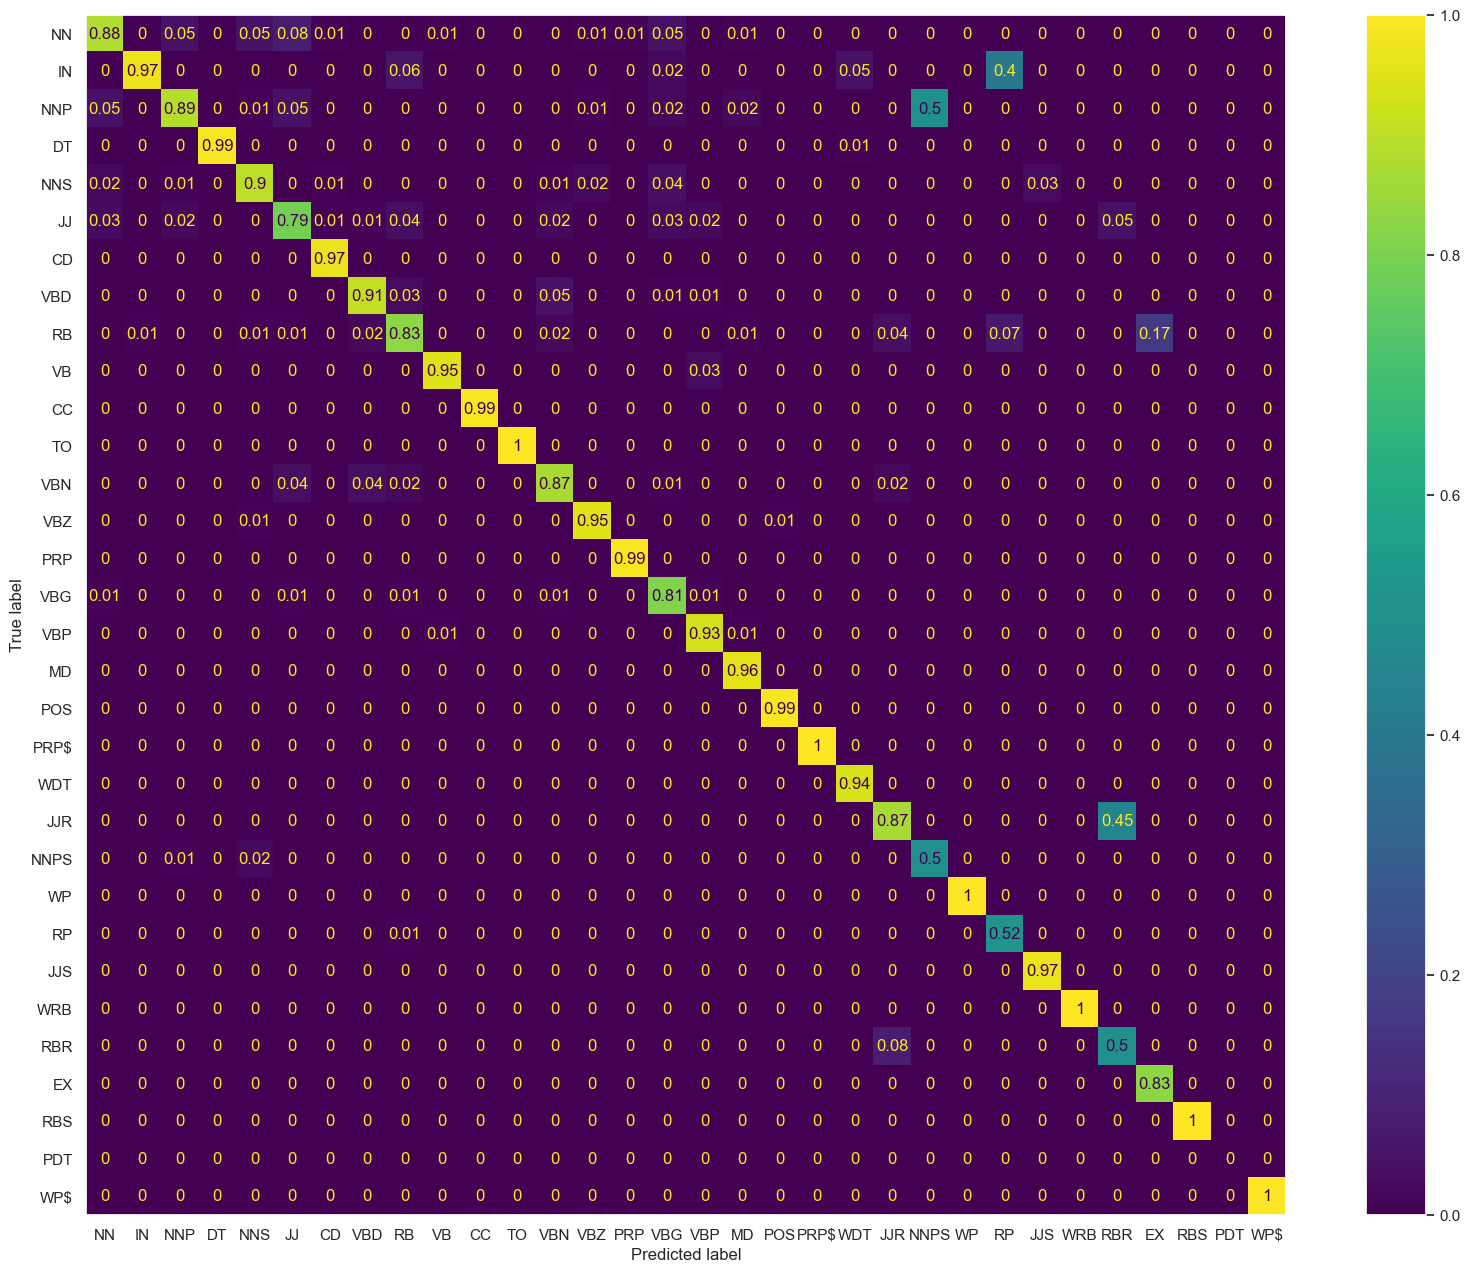

In [33]:
display(Markdown('**Test set - confusion matrix normalized by columns**'))
normalized_cm = np.around(normalize(f1_macro_test.cm, axis=0, norm='l1'), decimals = 2)
plot_confusion(normalized_cm, plt_size=(16,12),labels=pos_labels_test)

The confusion matrix, visualized by columns
- confirms the resemblance between NNP and NNPS: Not just NNPS is mismatched as NNP (seen before), but half of the time that we predict NNPS it is NNP instead.
- confirms the resemblance between RBR and JJR: Not just RBR is mismatched as JJR (seen before), but almost half of the times that we predict RBR it is JJR instead.
- PDT vanishes, because of its low support

### Comparing validation and test sets

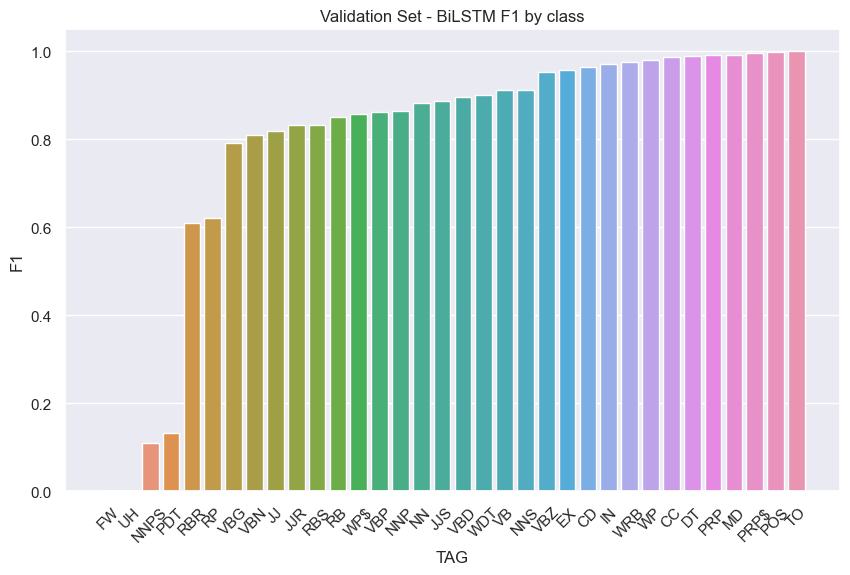

In [34]:
get_worst_errors(val_metric_info, pos_labels_val, plt_size=(10,6), title="Validation Set - BiLSTM F1 by class");
plt.show()

**Validation set - confusion matrix normalized by rows**

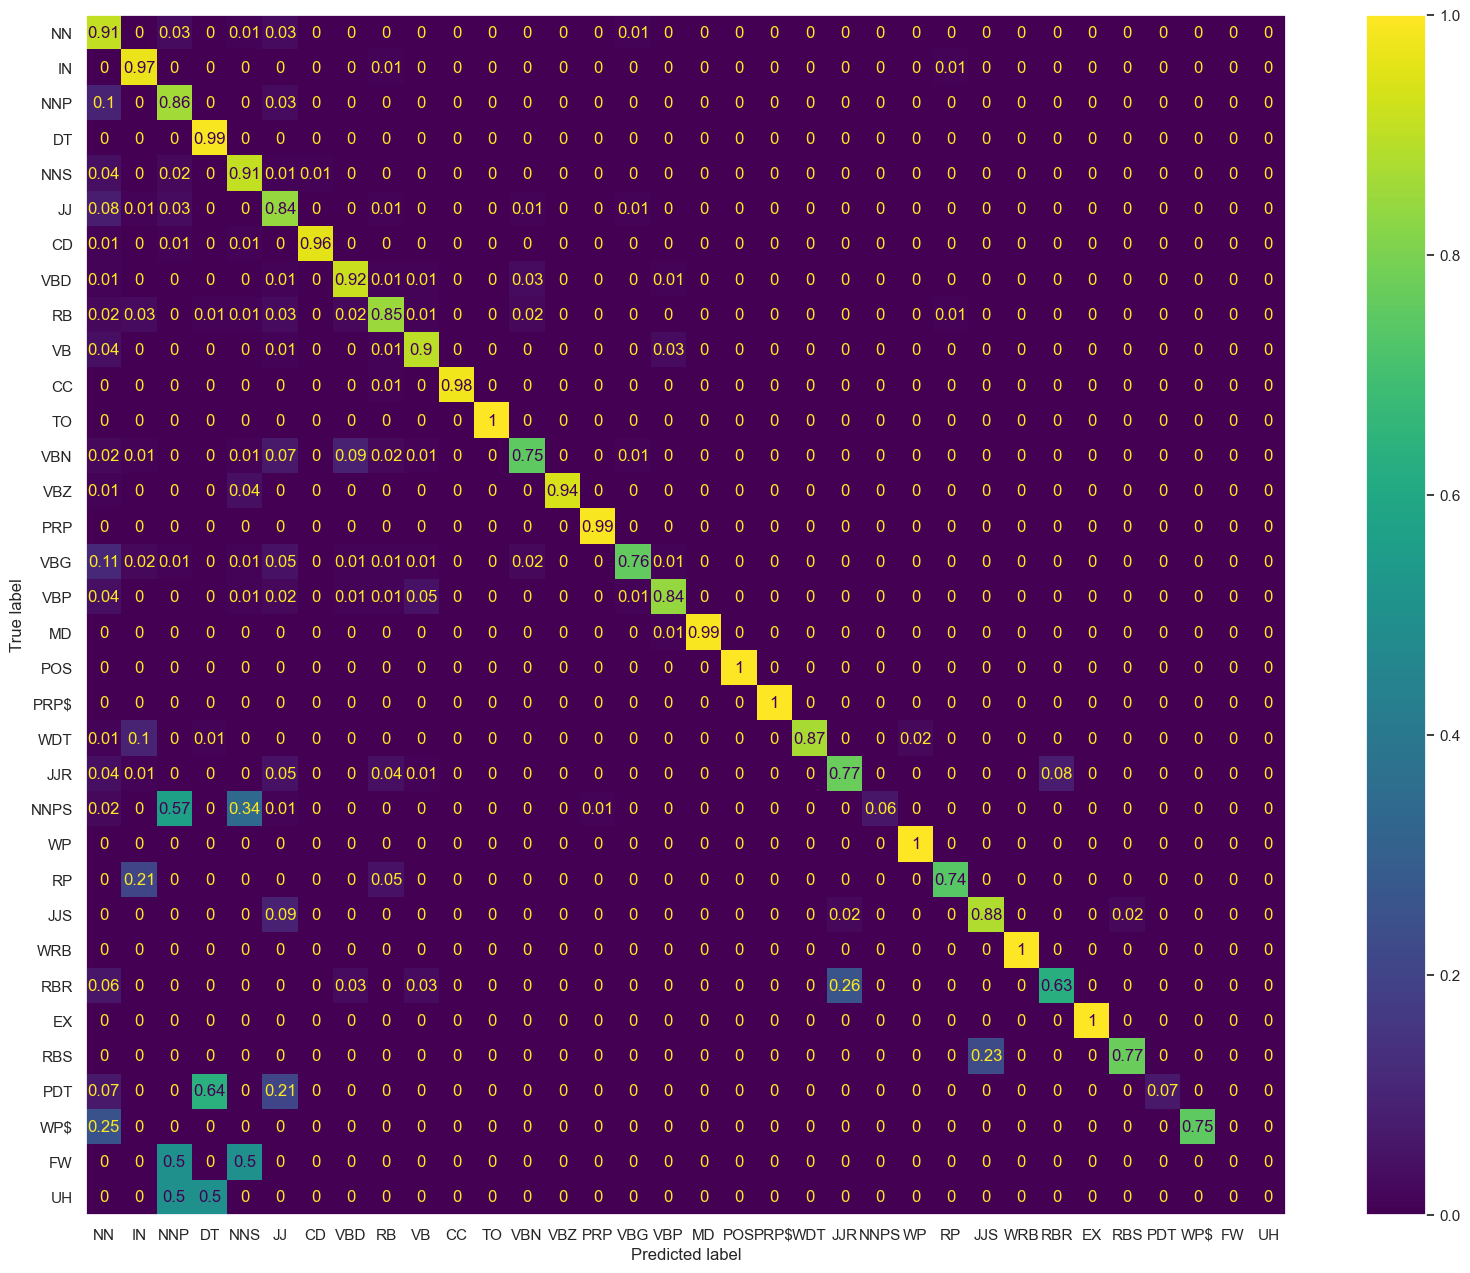

In [35]:
display(Markdown('**Validation set - confusion matrix normalized by rows**'))
normalized_cm = np.around(normalize(f1_macro_val.cm, axis=1, norm='l1'), decimals = 2)
plot_confusion(normalized_cm, plt_size=(16,12),labels=pos_labels_val)

**Validation set - confusion matrix normalized by columns**

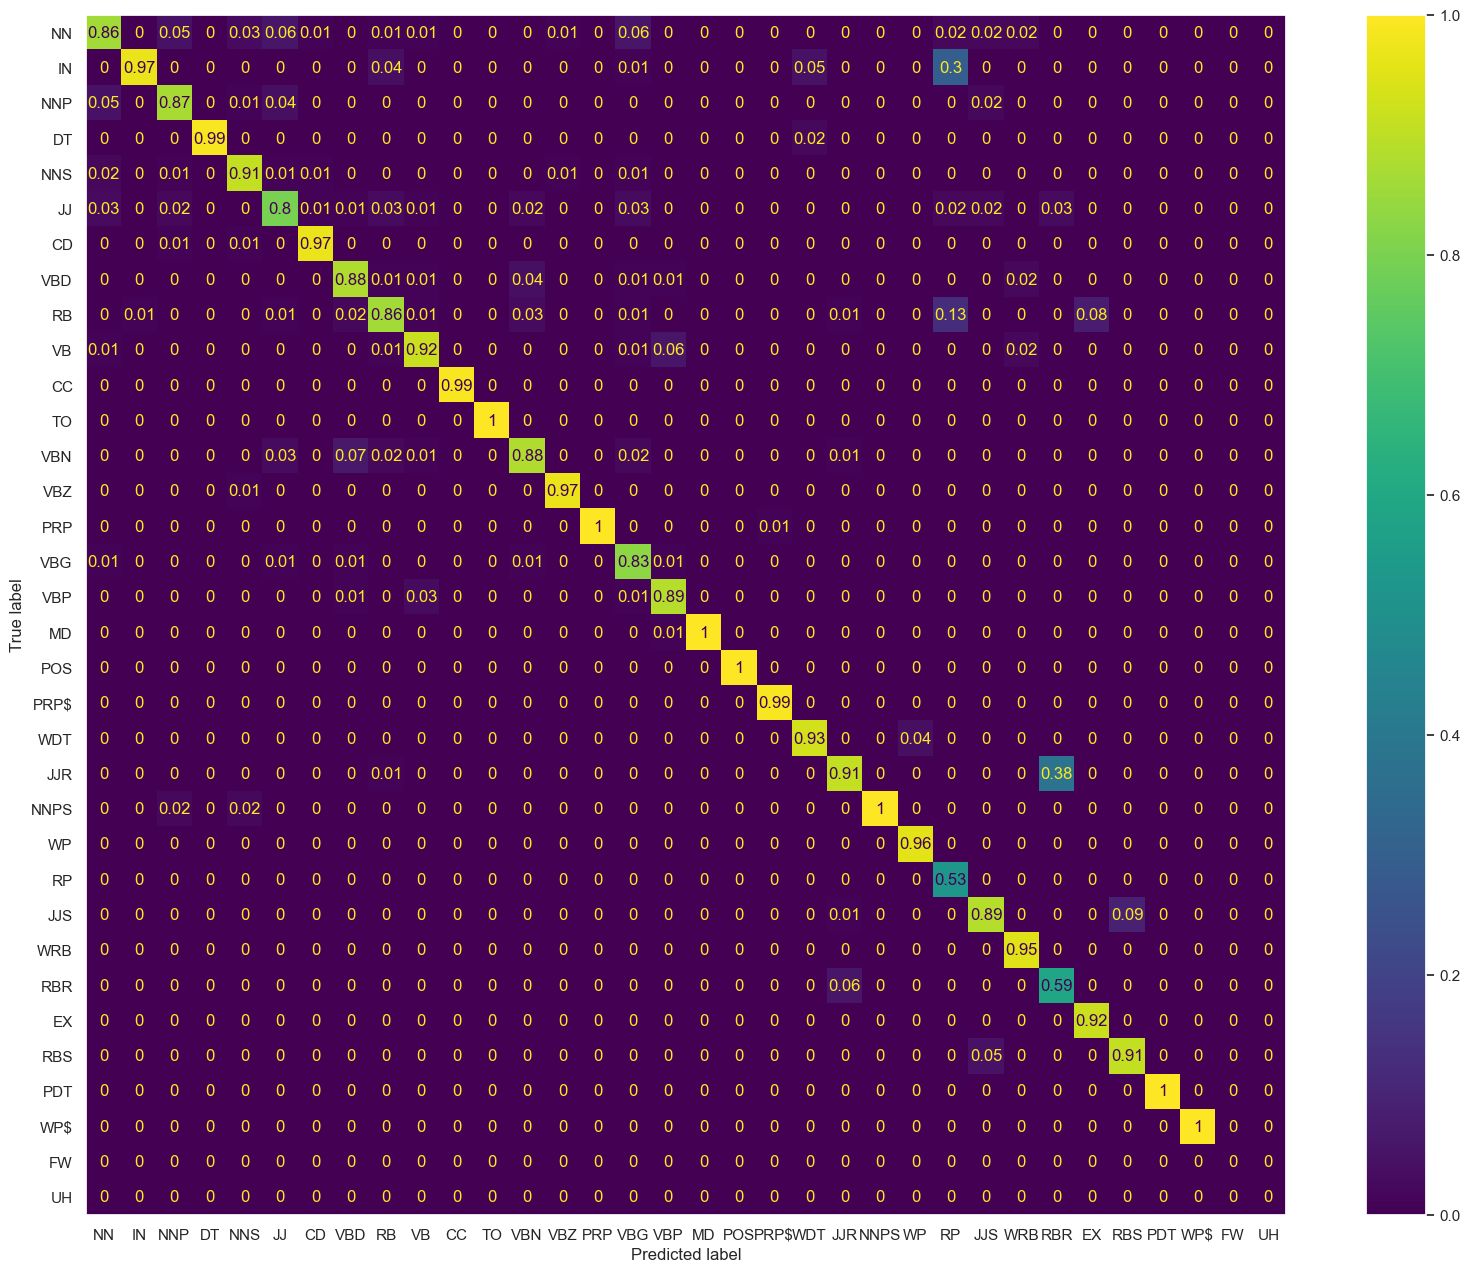

In [36]:
display(Markdown('**Validation set - confusion matrix normalized by columns**'))
normalized_cm = np.around(normalize(f1_macro_val.cm, axis=0, norm='l1'), decimals = 2)
plot_confusion(normalized_cm, plt_size=(16,12),labels=pos_labels_val)

Comparing the validation set results with the test set results commented before, we can notice that there are two minority classes more in the validation set for which there weren't samples in the test set: *FW* and *UH*. Those classes push down the final macro-F1 score, while other classes such as *RBR* and *RP* get slightly higher $F_1$ scores: this may be caused by the fact that the distribution of the predicted data resembles more the distribution of the classification strategy for each tag, but also because using an early stopping procedure based on validation scores we're slightly biasing the model towards validation scores. In any case, the better performance of some tags doesn't compensate for the bad performances of *FW* and *UH*.     

### Analysis of the train set samples

In [37]:
sentences_to_show = 4
y_pred = test_predictions_bilstm
print_worst_sentences(pos_tokenizer= pos_tokenizer.vocab, y_pred = y_pred, y_test = y_test, test_data = test_data, n_sentences = sentences_to_show);

Sentence n.549, Word n. 6


**Correct tagging**

,0,1,2,3,4,5,6,7,8,9
0,``,It,is,going,to,be,real,tight,.,''
0,``,PRP,VBZ,VBG,TO,VB,RB,JJ,.,''


**Predicted tagging**

,0,1,2,3,4,5,6,7,8,9
0,``,It,is,going,to,be,real,tight,.,''
0,``,PRP,VBZ,VBG,TO,VB,JJ,NN,.,''


_____________________________________________________________ 
 

Sentence n.487, Word n. 21


**Correct tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,Absorbed,in,doling,out,``,Feeding,Frenzy,'s,'',tidbits,",",the,authors,gloss,over,the,root,causes,of,Wedtech,",",namely,the,Section,8,-LRB-,A,-RRB-,federal,program,under,whose,auspices,the,scandal,took,place,.
0,VBN,IN,VBG,RP,``,NNP,NNP,POS,'',NNS,",",DT,NNS,VBP,IN,DT,NN,NNS,IN,NNP,",",RB,DT,NN,CD,-LRB-,NN,-RRB-,JJ,NN,IN,WP$,NNS,DT,NN,VBD,NN,.


**Predicted tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,Absorbed,in,doling,out,``,Feeding,Frenzy,'s,'',tidbits,",",the,authors,gloss,over,the,root,causes,of,Wedtech,",",namely,the,Section,8,-LRB-,A,-RRB-,federal,program,under,whose,auspices,the,scandal,took,place,.
0,VBN,IN,VBG,RP,``,VBG,NN,POS,'',NNS,",",DT,NNS,VBP,IN,DT,NN,NN,IN,NN,",",VBG,DT,NN,CD,-LRB-,DT,JJ,JJ,NN,IN,NN,VBN,DT,NN,VBD,NN,.


_____________________________________________________________ 
 

Sentence n.483, Word n. 15


**Correct tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,The,scammers,themselves,were,garden-variety,low,lifes,",",conspicuous,consumers,who,wanted,big,houses,",",Mercedes,cars,",",beautiful,women,",",expensive,clothes,.
0,DT,NNS,PRP,VBD,NN,JJ,NNS,",",JJ,NNS,WP,VBD,JJ,NNS,",",NNPS,NNS,",",JJ,NNS,",",JJ,NNS,.


**Predicted tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,The,scammers,themselves,were,garden-variety,low,lifes,",",conspicuous,consumers,who,wanted,big,houses,",",Mercedes,cars,",",beautiful,women,",",expensive,clothes,.
0,DT,NNS,PRP,VBD,JJ,JJ,NNS,",",JJ,NNS,WP,VBD,JJ,NNS,",",JJ,NNS,",",JJ,NNS,",",JJ,NNS,.


_____________________________________________________________ 
 

Sentence n.422, Word n. 7


**Correct tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,The,ABA,gives,a,``,qualified,'',rating,to,nominees,it,believes,would,perform,``,satisfactorily,'',on,the,bench,.
0,DT,NNP,VBZ,DT,``,VBN,'',VBG,TO,NNS,PRP,VBZ,MD,VB,``,RB,'',IN,DT,NN,.


**Predicted tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,The,ABA,gives,a,``,qualified,'',rating,to,nominees,it,believes,would,perform,``,satisfactorily,'',on,the,bench,.
0,DT,NNP,VBZ,DT,``,JJ,'',NN,TO,NNS,PRP,VBZ,MD,VB,``,RB,'',IN,DT,NN,.


_____________________________________________________________ 
 



- **Sentence n.549, Word n. 6**: the word *real* is used as if it was *really*. The mistaken made by the model (classifying it as adjective instead of adverb) is conceivable and its probably because the word doesn't end in -y or -ly as most of the adverbs.  
- **Sentence n.487, Word n. 21**: the adverb *namely* was wrongly classified as gerund verb probably because *the section 8(A)* was understood by the model as the direct object of the sentence (and not as the subject). This error can be avoided improving the training.
- **Sentence n.483, Word n. 15**: in this case, *Mercedes* is both a name and an adjective, but the right tag is NNPS, probably because of some tagging conventions chosen by the dataset annotators. The misclassification as adjective instead of noun is understandable. Consider also the fact that car brands could be not very frequent in this dataset.
- **Sentence n.422, Word n. 7**: the word *rating* refers to a name, a grade, not to the act of "rating". This is testified also by the preceding adjective "qualified". The behavior of the model can be consider legit. It is likely to be an error of the annotator or at least a questionable original classification.



### Analysis of the validation set samples

In [38]:
sentences_to_show = 4
y_pred = val_predictions_bilstm
print_worst_sentences(pos_tokenizer= pos_tokenizer.vocab, y_pred = y_pred, y_test = y_val, test_data = validation_data, n_sentences = sentences_to_show);

Sentence n.359, Word n. 15


**Correct tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,If,President,Bush,loses,at,the,court,",",it,might,be,disappointing,",",as,Morrison,v.,Olson,was,for,the,Reagan,administration,.
0,IN,NNP,NNP,VBZ,IN,DT,NN,",",PRP,MD,VB,JJ,",",IN,NNP,CC,NNP,VBD,IN,DT,NNP,NN,.


**Predicted tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,If,President,Bush,loses,at,the,court,",",it,might,be,disappointing,",",as,Morrison,v.,Olson,was,for,the,Reagan,administration,.
0,IN,NNP,NNP,VBZ,IN,DT,NN,",",PRP,MD,VB,JJ,",",IN,NNP,NNP,NNP,VBD,IN,DT,NNP,NN,.


_____________________________________________________________ 
 

Sentence n.1158, Word n. 26


**Correct tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,In,a,surprise,announcement,",",the,Treasury,said,it,will,reopen,the,outstanding,benchmark,30-year,bond,rather,than,create,a,new,one,for,next,week,'s,quarterly,refunding,of,the,federal,debt,.
0,IN,DT,NN,NN,",",DT,NNP,VBD,PRP,MD,VB,DT,JJ,NN,JJ,NN,RB,IN,VB,DT,JJ,CD,IN,JJ,NN,POS,RB,NN,IN,DT,JJ,NN,.


**Predicted tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,In,a,surprise,announcement,",",the,Treasury,said,it,will,reopen,the,outstanding,benchmark,30-year,bond,rather,than,create,a,new,one,for,next,week,'s,quarterly,refunding,of,the,federal,debt,.
0,IN,DT,NN,NN,",",DT,NNP,VBD,PRP,MD,VB,DT,JJ,NN,JJ,NN,RB,IN,VB,DT,JJ,NN,IN,JJ,NN,POS,JJ,NNS,IN,DT,JJ,NN,.


_____________________________________________________________ 
 

Sentence n.341, Word n. 7


**Correct tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,The,Supreme,Court,'s,decision,in,INS,v.,Chadha,held,that,legislative,vetoes,are,unconstitutional,.
0,DT,NNP,NNP,POS,NN,IN,NNP,CC,NNP,VBD,IN,JJ,NNS,VBP,JJ,.


**Predicted tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,The,Supreme,Court,'s,decision,in,INS,v.,Chadha,held,that,legislative,vetoes,are,unconstitutional,.
0,DT,NN,NN,POS,NN,IN,NNP,NNP,NNP,VBD,DT,JJ,NNS,VBP,JJ,.


_____________________________________________________________ 
 

Sentence n.985, Word n. 6


**Correct tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,The,ultimate,result,came,in,Hymowitz,v.,Lilly,",",where,the,highest,New,York,court,expanded,the,market-share,approach,for,the,first,time,to,say,that,drug,makers,that,could,prove,Mindy,Hymowitz,'s,mother,did,n't,use,their,pill,must,still,pay,their,share,of,any,damages,.
0,DT,JJ,NN,VBD,IN,NNP,CC,NNP,",",WRB,DT,JJS,NNP,NNP,NN,VBD,DT,JJ,NN,IN,DT,JJ,NN,TO,VB,IN,NN,NNS,WDT,MD,VB,NNP,NNP,POS,NN,VBD,RB,VB,PRP$,NN,MD,RB,VB,PRP$,NN,IN,DT,NNS,.


**Predicted tagging**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,The,ultimate,result,came,in,Hymowitz,v.,Lilly,",",where,the,highest,New,York,court,expanded,the,market-share,approach,for,the,first,time,to,say,that,drug,makers,that,could,prove,Mindy,Hymowitz,'s,mother,did,n't,use,their,pill,must,still,pay,their,share,of,any,damages,.
0,DT,JJ,NN,VBD,IN,NNP,NNP,NNP,",",WRB,DT,JJS,NNP,NNP,NN,VBD,DT,JJ,NN,IN,DT,JJ,NN,TO,VB,IN,NN,NNS,WDT,MD,VB,NNP,NNP,POS,NN,VBD,RB,VB,PRP$,NN,MD,RB,VB,PRP$,NN,IN,DT,NN,.


_____________________________________________________________ 
 



- **Sentence n.359, Word n. 15**: the sentence refers to a supreme court (*Morrison v. Olson*): in this case the *v.* has the same function of *vs.*: the fact that this is not an initial of a name but a coordinating conjunction can be understood just from the fact that it is not a capital letter, but if we want to make a deeper analysis, we can hypothesize that this word wasn't in glove (and maybe not even in the train set) and a random embedding (with ambiguous semantic meaning) was given to it, resulting in a mistake by the model. A solution would be to lemmatize all *v.* and *vs.* in *versus*. 
- **Sentence n.1158, Word n. 26**: *quarterly* is both an adjective and an adverb. It is hard to tell the two things apart in this setence. The classification was done by the annotators using conventions that are not fully captured by the model.
- **Sentence n.341, Word n. 7**: same case of *Sentence n.359, Word n. 15*
- **Sentence n.985, Word n. 6**: same case of *Sentence n.359, Word n. 15*

## BiGRU Error Analysis

### Metrics analysis and confusion matrixes

In [39]:
# Val data
remove_classes_val, pos_labels_val = obtain_remove_kept_tags(pos_tokenizer = pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = val_predictions_bigru, gold_labels=y_val)

f1_val = F1_Metric(average=None,categorical=True,remove_classes=remove_classes_val)
f1_macro_val = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes_val)
accuracy_val = Accuracy_Metric(categorical=True,remove_classes=remove_classes_val)


val_metric_info = evaluate_predictions(predictions=val_predictions_bigru,
                                   y= y_val,
                                   metrics=[f1_val, f1_macro_val],
                                   metric_names=["f1", "f1_macro"])



# Test data
remove_classes_test, pos_labels_test = obtain_remove_kept_tags(pos_tokenizer = pos_tokenizer, punctuation_tags = dataset_punctuations,
                                   predicted_values = test_predictions_bigru, gold_labels=y_test)

f1_test = F1_Metric(average=None,categorical=True,remove_classes=remove_classes_test)
f1_macro_test = F1_Metric(average='macro',categorical=True,remove_classes=remove_classes_test)
accuracy_test = Accuracy_Metric(categorical=True,remove_classes=remove_classes_test)


test_metric_info = evaluate_predictions(predictions=test_predictions_bigru,
                                   y= y_test,
                                   metrics=[f1_test, f1_macro_test],
                                   metric_names=["f1", "f1_macro"])



Evaluating predictions! Total samples: 1299
Evaluating predictions! Total samples: 652


detect the POS tags having the lowest $F_1$ score:

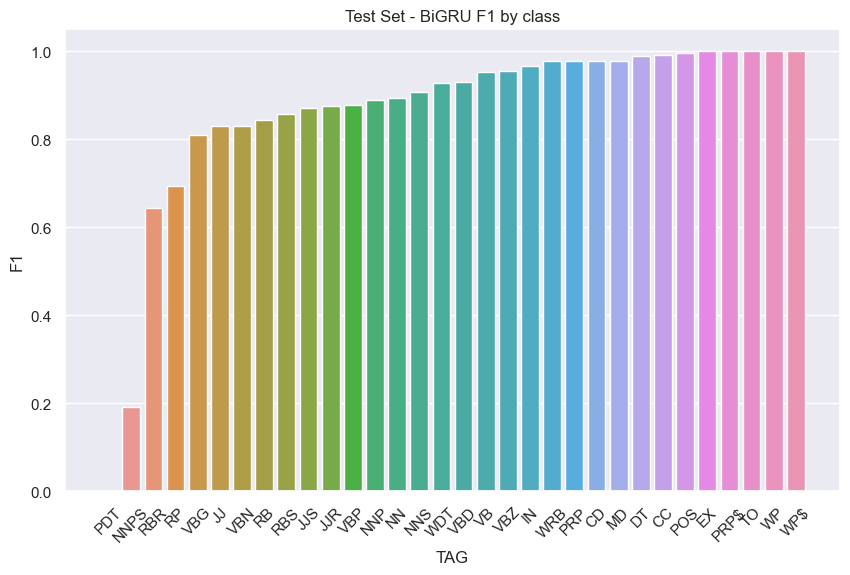

In [40]:
get_worst_errors(test_metric_info, pos_labels_test, plt_size=(10,6), title="Test Set - BiGRU F1 by class");
plt.show()

We avoided this section because the conclusions were similar to the ones taken on the BiLSTM model.

**Test set - confusion matrix normalized by rows**

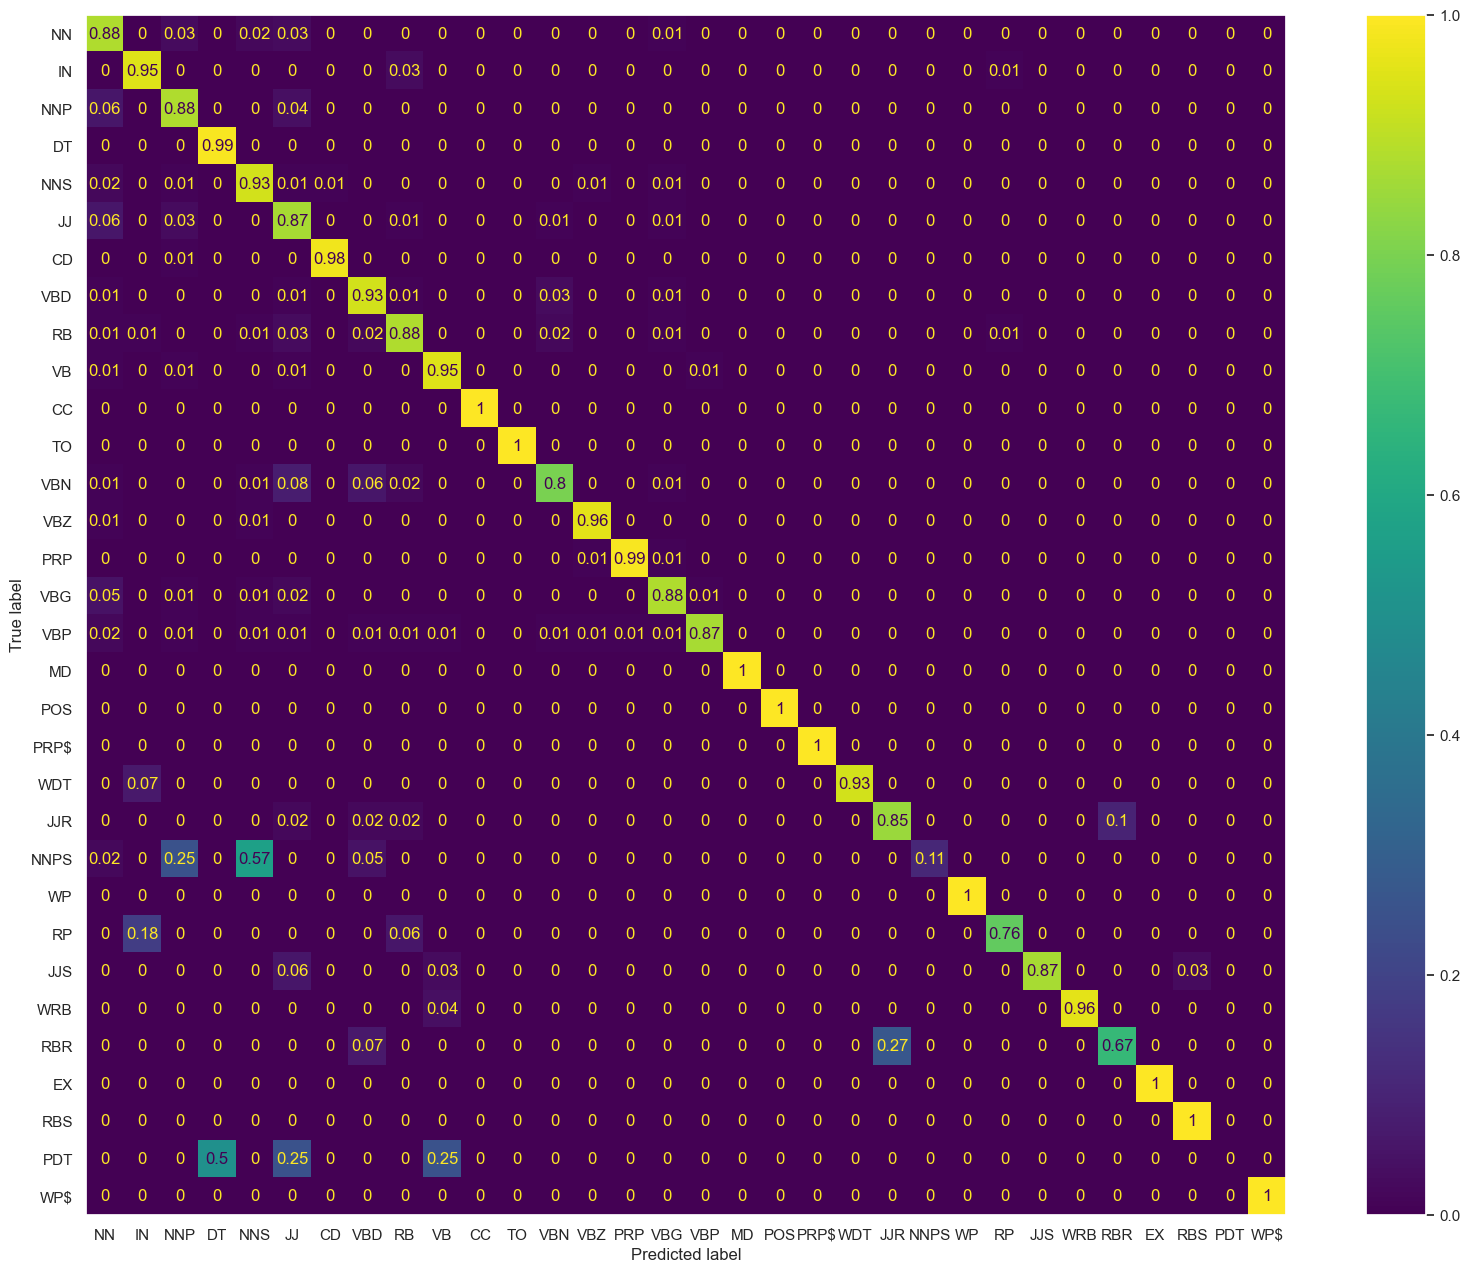

In [41]:
display(Markdown('**Test set - confusion matrix normalized by rows**'))
normalized_cm = np.around(normalize(f1_macro_test.cm, axis=1, norm='l1'), decimals = 2)
plot_confusion(normalized_cm, plt_size=(16,12),labels=pos_labels_test)

**Test set - confusion matrix normalized by columns**

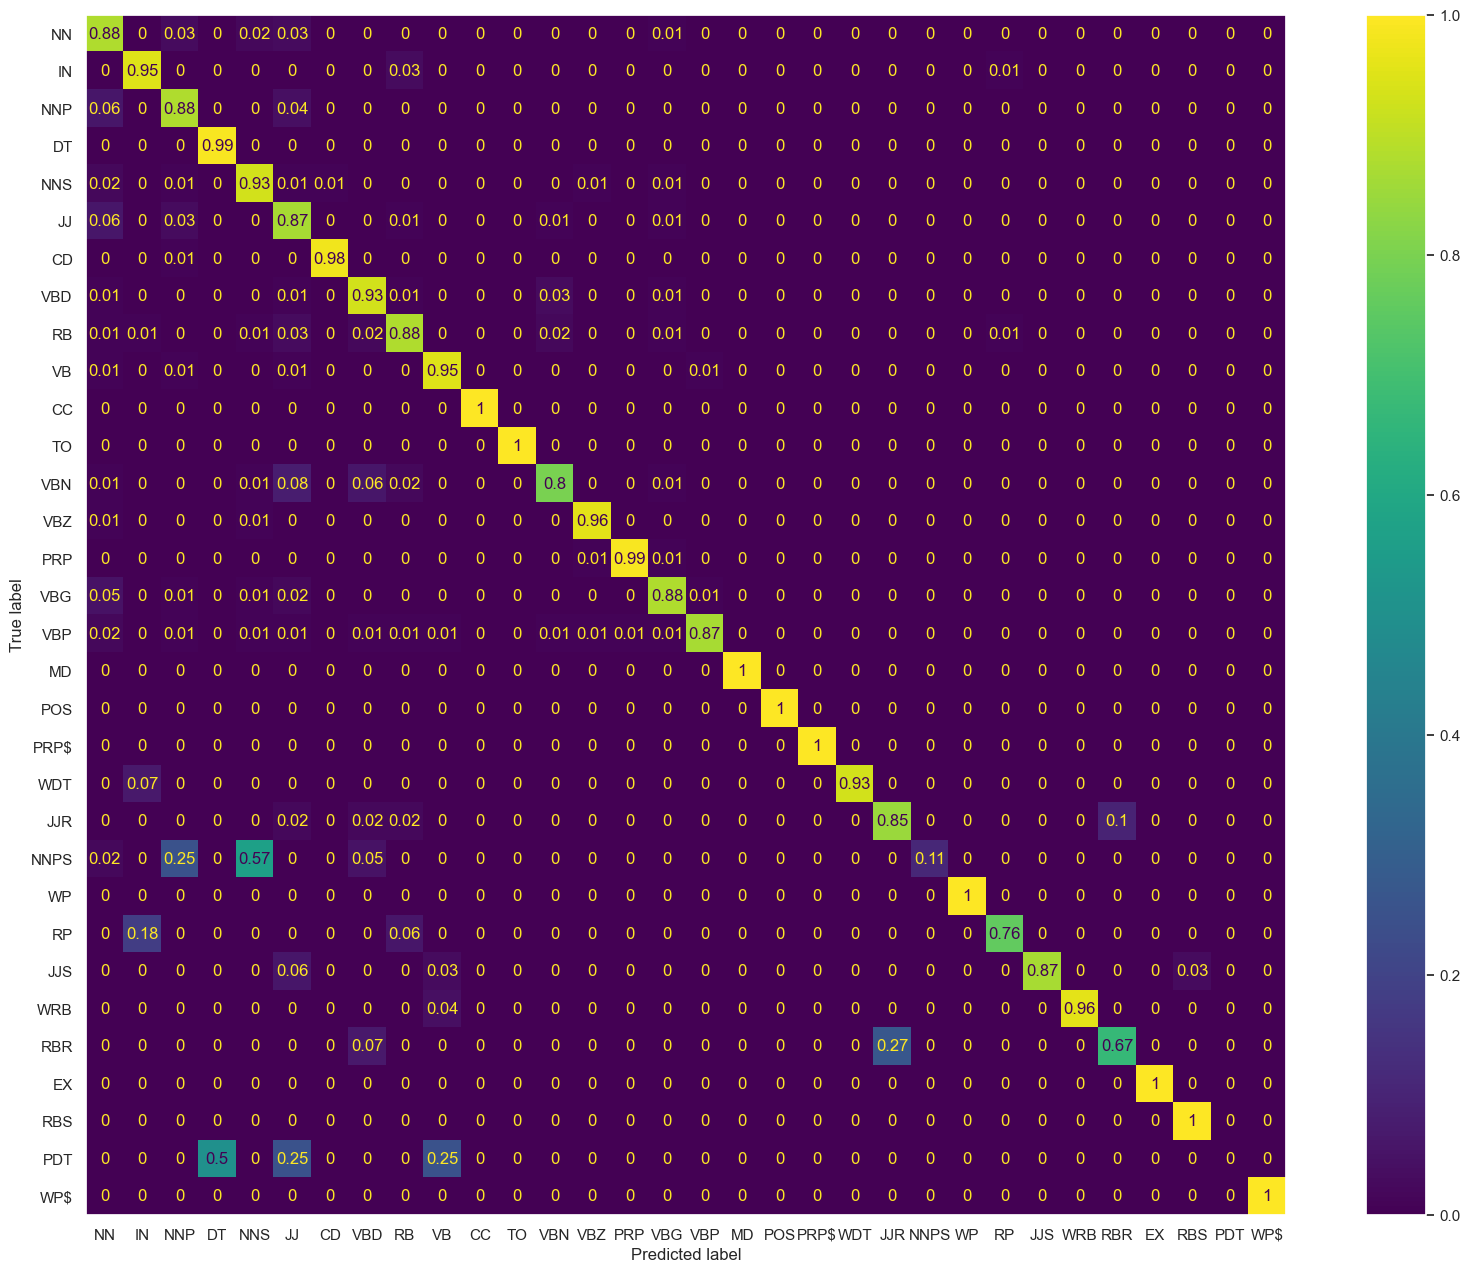

In [42]:
display(Markdown('**Test set - confusion matrix normalized by columns**'))
normalized_cm = np.around(normalize(f1_macro_test.cm, axis=1, norm='l1'), decimals = 2)
plot_confusion(normalized_cm, plt_size=(16,12),labels=pos_labels_test)

We avoided this section because the conclusions were similar to the ones taken on the BiLSTM model.

- *PDT* mistaken also with *VB*: again, an error caused by the scarcity of *PDT* examples
For the rest, the conclusions are the same of the ones taken for the BiLSTM model

### Comparing validation and test sets

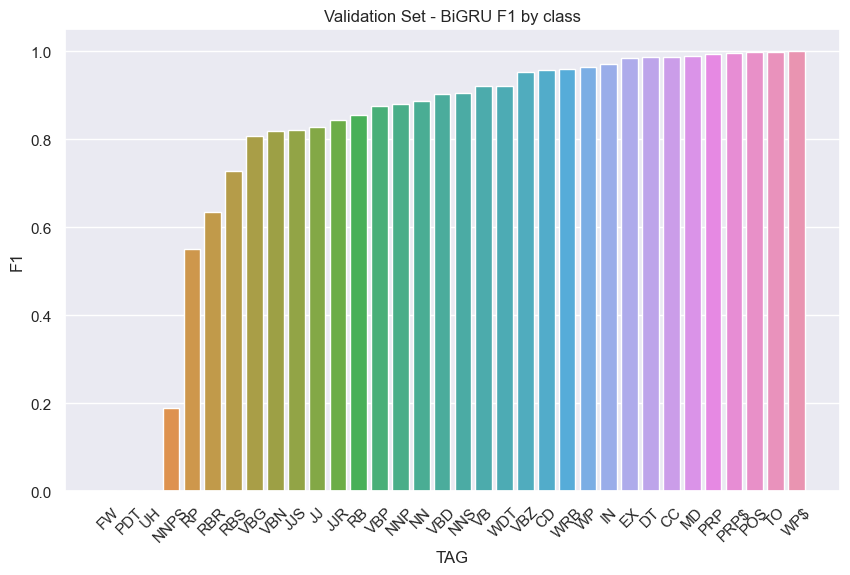

In [43]:
get_worst_errors(val_metric_info, pos_labels_val, plt_size=(10,6), title="Validation Set - BiGRU F1 by class");
plt.show()

We avoided this section because the conclusions were similar to the ones taken on the BiLSTM model.

**Validation set - confusion matrix normalized by rows**

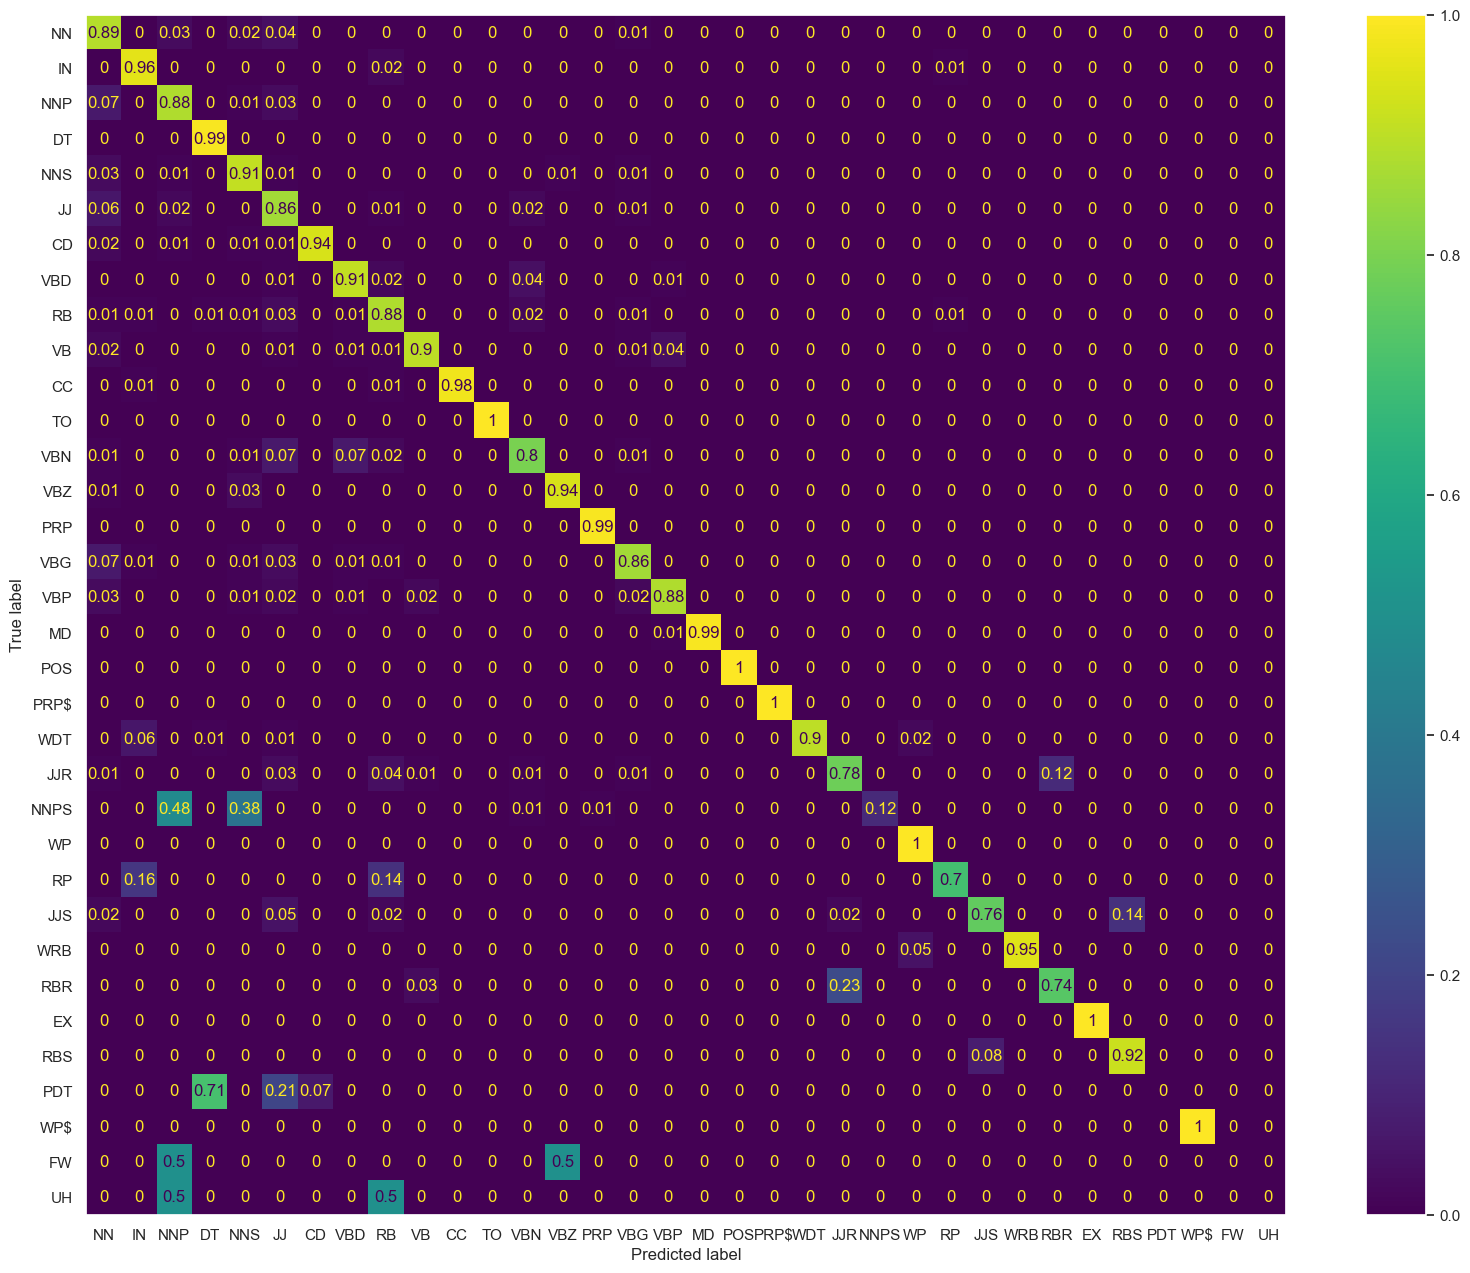

In [44]:
display(Markdown('**Validation set - confusion matrix normalized by rows**'))
normalized_cm = np.around(normalize(f1_macro_val.cm, axis=1, norm='l1'), decimals = 2)
plot_confusion(normalized_cm, plt_size=(16,12),labels=pos_labels_val)

**Validation set - confusion matrix normalized by columns**

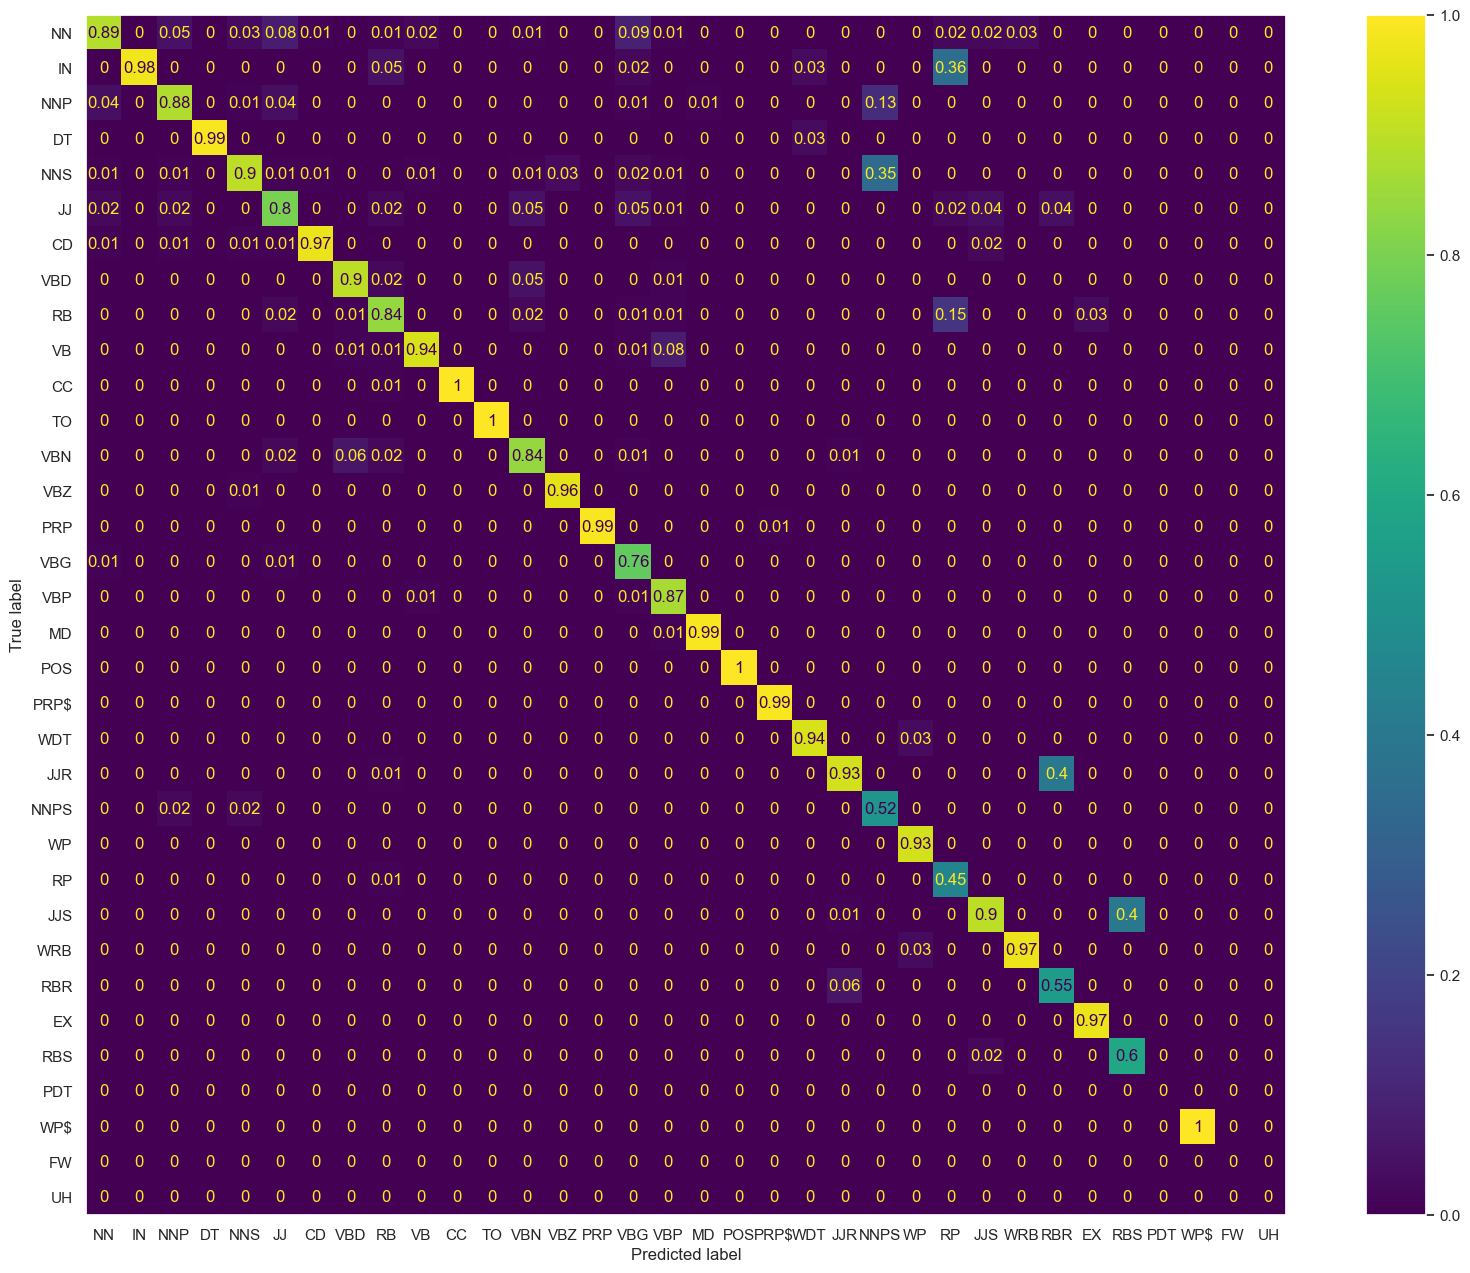

In [45]:
display(Markdown('**Validation set - confusion matrix normalized by columns**'))
normalized_cm = np.around(normalize(f1_macro_val.cm, axis=0, norm='l1'), decimals = 2)
plot_confusion(normalized_cm, plt_size=(16,12),labels=pos_labels_val)

We avoided this section because the conclusions were similar to the ones taken on the BiLSTM model.

### Analysis of the samples

We avoided this section because the conclusions were similar to the ones taken on the BiLSTM model.

## Conlusions

In conclusion, we can say that the model performs quite well both in terms of accuracy and $F_1$ score. The imbalanced nature of the dataset makes it perform better on the most numerous classes (the ones having higher support), while the minority classes are frequently mismatched: this is because the limited number of these instances in the dataset is not big enough to learn their features and, at the same time, the model gets partially biased towards similar (but more numerous) classes.
Another source of errors is the ambiguity of the role of some tags in the sentences: if the tags would have been multiple and guessing one class would have been enough, this problem would be overcome, but instead the annotators decided to give a single class to each word: this is a simplification that forces the use of some conventions (some kind of "right-hand rules") and sometimes leads to the increase of the ambiguity inside the model - which possibly could have learn them using more samples containing those conflicting TAGs.

## Possible improvements

Some improvements can be obtained:
- using a trained model (even another LSTM) to generate better contextual embeddings for OOV words
- using a bigger model for the whole process (this may have a higher cost both at train and at inference time)
- using bigger embeddings, 200-300 (in this case also the contextual embedding of the LSTM/GRU and other parameters numbera have to be increased)
- using regularization techniques (such as Dropout, Recurrent Dropout, L2), which we didn't apply to avoid misinterpretations of the given assignment
- using libraries to augment the data of the smaller class tags
- allowing the training of the Glove embeddings (which in this assignment is prohibited), which could refine the embeddings of Glove using the actual context and could give a better embedding for OOV words. In this case the way we've built the dictionary could influence the whole process. Embeddings "not requested" should be anyway blocked - this is not an easy modification 
- lemmatizing some words 
    - for example, *v.* and *vs.* in *versus* (take a look to the error analysis)
- an ensemble between the analyzed models wouldn't be very useful because they tend to make the same errors and the parameter number would double